In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import collections
import ipynb.fs.full.Structural_Perturbations as SP
import ipynb.fs.full.MultiTest as MT
tf.logging.set_verbosity(tf.logging.ERROR)
import sys

/home/uttaran/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/uttaran/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Data has apparently already been downloaded and unpacked.


Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


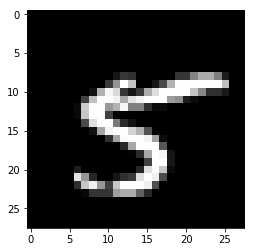

In [35]:
train_data,train_labels,eval_data,eval_labels = SP.load(data='mnist')
SP.Display(eval_data,433)

In [16]:
eval_data = SP.Scaling(eval_data,.8)

In [18]:
eval_data = Exposure(eval_data,+60)

In [46]:
eval_data = Rotation(eval_data,10)

In [69]:
eval_data = Translation(eval_data,2)

In [36]:
data = np.empty([train_data.shape[0],train_data.shape[1]+1])
for i in range (0,data.shape[0]):
    data[i] = np.append(train_data[i],int(train_labels[i]))
data = data[data[:,784].argsort()]
a = 0.0
count=[]
for i in range (0,data.shape[0]):
    if data[i,784]!= a:
        count.append(i)
        a += 1
count.append(data.shape[0]-1)
count = np.array(count)
a = 0
digit = []
s = 0
while a!=count.shape[0]:
    digit.append(data[s:count[a]])
    s = count[a]
    a +=1
digit = np.array(digit)
for i in range(0,digit.shape[0]):
    digit[i] = np.delete(digit[i],[784], axis=1)

In [37]:
samples = 15
ref = np.empty([8*samples,784])
cur = samples
prev = 0
for i in range(0,10):
    if i==6 or i==9:
        continue
    s = digit[i].shape[0]
    p = np.random.choice(s, samples, replace=False)
    for j in range(prev,cur):
        ref[j] = digit[i][p[j%samples]]
    prev = cur
    cur +=samples
print(ref.shape)

(120, 784)


In [38]:
database = []#np.empty(784)
rot = [0,45,90,135,180,225,270,315]
for j in rot:
    o = SP.Rotation(ref,j)
    for k in o:
        database.append(k)

In [39]:
database = np.array(database)
print(database.shape)

(960, 784)


In [40]:
temp =[]
for i in database:
    temp.append(cv2.flip(i,flipCode=1))

In [41]:
temp = np.array(temp)
temp.shape

(960, 784, 1)

In [42]:
temp = temp.reshape(temp.shape[0],temp.shape[1])

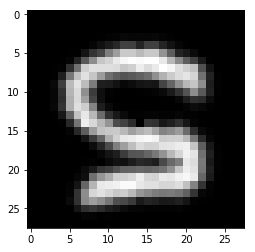

In [43]:
SP.Display(database,322)

In [44]:
database = np.concatenate((database,temp))

In [45]:
database.shape

(1920, 784)

In [46]:
train_data = np.float32(database)
train_labels = np.zeros(database.shape[0],dtype=np.int32)
label = [0,1,2,3,4,5,7,8]
c = 0
for o in range (0,2):
    for p in range (0,8):
        for i in range (0,8):
            for j in range(0,samples):
                train_labels[c] = label[i]
                c+=1

In [47]:
temp = np.random.randint(0,10000,min(np.int(database.shape[0]/5),10000))

In [48]:
temp.shape

(384,)

In [49]:
evald = []
evall = []
for i in temp:
    if eval_labels[i]== 6 or eval_labels[i]==9 :
        continue
    evald.append(eval_data[i])
    evall.append(eval_labels[i])

In [50]:
eval_data,eval_labels = np.array(evald),np.array(evall)

7


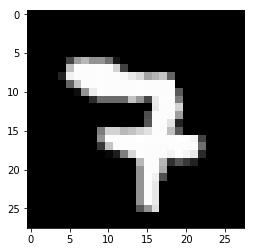

In [51]:
p = 144
SP.Display(eval_data,p)
print(eval_labels[p])

In [52]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=1,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=4)

#     conv2 = tf.layers.conv2d(
#         inputs=pool1,
#         filters=16,
#         kernel_size=[5, 5],
#         padding="same",
#         activation=tf.nn.relu)

#     pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    pool2_flat = tf.reshape(pool1, [-1, 7 * 7 * 1])

#     dense = tf.layers.dense(inputs=pool2_flat, units=5, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
        inputs=pool2_flat, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)

        #"classes": temp,
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(
            mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy":
        tf.metrics.accuracy(labels=labels, predictions=predictions["classes"]),
    }
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [53]:
# Evaluate the model and print results
mnist_classifier = tf.estimator.Estimator(
  model_fn=cnn_model_fn, model_dir="./models/mnist_rotated_model_15_samples")

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors=tensors_to_log, every_n_iter=50)

In [ ]:
print("started\n")
# Train the model
print("Training Data = ",database.shape[0])
print("Test Data = ",eval_data.shape[0])
while 1:

# Train the model
    print("Training")
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=256,
      num_epochs=None,
      shuffle=True)

    mnist_classifier.train(
      input_fn=train_input_fn,
      steps=1000,
      hooks=[logging_hook])
    SP.Test(train_data, train_labels, eval_data, eval_labels,
                           mnist_classifier)
#     print(curr_result)
#     if curr_result[0] - curr_result[1] > 0.10 or curr_result[1] > 0.98:
#        break
    #print(curr_result)
    
print ("Finished")

started

Training Data =  1920
Test Data =  316
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.89166665, 'loss': 0.4079501, 'global_step': 9004}
######### Test accuracy #############
 {'accuracy': 0.33544305, 'loss': 4.741211, 'global_step': 9004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.93333334, 'loss': 0.35414663, 'global_step': 10004}
######### Test accuracy #############
 {'accuracy': 0.32594937, 'loss': 5.3468823, 'global_step': 10004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.93333334, 'loss': 0.32628828, 'global_step': 11004}
######### Test accuracy #############
 {'accuracy': 0.32594937, 'loss': 5.900305, 'global_step': 11004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.94166666, 'loss': 0.3128926, 'global_step': 12004}
######### Test accuracy #############
 {'accuracy': 0.32911393, 'loss': 6.508859, 'global_step': 12004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.94166666, 'loss': 0.297409

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.22598632, 'global_step': 47004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 24.23923, 'global_step': 47004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.22960849, 'global_step': 48004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 24.887964, 'global_step': 48004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.22798467, 'global_step': 49004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 25.412941, 'global_step': 49004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.23211916, 'global_step': 50004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 25.709547, 'global_step': 50004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.229573, 'global_step': 51004}
######### Test accuracy #########

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.21774605, 'global_step': 85004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 41.36568, 'global_step': 85004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.21563895, 'global_step': 86004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 41.897793, 'global_step': 86004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.21737474, 'global_step': 87004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 42.20668, 'global_step': 87004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.21703105, 'global_step': 88004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 42.547413, 'global_step': 88004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.21530508, 'global_step': 89004}
######### Test accuracy ###########

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20772968, 'global_step': 123004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 53.10815, 'global_step': 123004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.2126414, 'global_step': 124004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 53.33514, 'global_step': 124004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20737451, 'global_step': 125004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 53.651855, 'global_step': 125004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20819215, 'global_step': 126004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 53.782955, 'global_step': 126004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.21065697, 'global_step': 127004}
######### Test accuracy

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20845345, 'global_step': 161004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 60.23308, 'global_step': 161004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20725733, 'global_step': 162004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 60.49416, 'global_step': 162004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20832276, 'global_step': 163004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 60.764862, 'global_step': 163004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.95, 'loss': 0.20343837, 'global_step': 164004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 60.7914, 'global_step': 164004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20564418, 'global_step': 165004}
######### Test accuracy ##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20397094, 'global_step': 199004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 66.14307, 'global_step': 199004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20549488, 'global_step': 200004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 66.23397, 'global_step': 200004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20600408, 'global_step': 201004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 66.34427, 'global_step': 201004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.95, 'loss': 0.1991397, 'global_step': 202004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 66.55905, 'global_step': 202004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20838659, 'global_step': 203004}
######### Test accuracy ###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19932428, 'global_step': 237004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 71.056915, 'global_step': 237004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.20102017, 'global_step': 238004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 71.10645, 'global_step': 238004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.203079, 'global_step': 239004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 71.342354, 'global_step': 239004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20329389, 'global_step': 240004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 71.339424, 'global_step': 240004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.20403513, 'global_step': 241004}
######### Test accuracy ##########

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20535937, 'global_step': 275004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 74.93613, 'global_step': 275004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20092864, 'global_step': 276004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 75.05953, 'global_step': 276004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20467211, 'global_step': 277004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 75.19538, 'global_step': 277004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20080972, 'global_step': 278004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 75.45412, 'global_step': 278004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20223135, 'global_step': 279004}
######### Test accuracy

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20010854, 'global_step': 313004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 78.77085, 'global_step': 313004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20052002, 'global_step': 314004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 78.866295, 'global_step': 314004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20322452, 'global_step': 315004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 78.972404, 'global_step': 315004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20029911, 'global_step': 316004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 79.06991, 'global_step': 316004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19998823, 'global_step': 317004}
######### Test accur

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20358187, 'global_step': 351004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 82.17072, 'global_step': 351004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19975789, 'global_step': 352004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 82.29507, 'global_step': 352004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20148723, 'global_step': 353004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 82.485695, 'global_step': 353004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.201636, 'global_step': 354004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 82.30787, 'global_step': 354004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19820103, 'global_step': 355004}
######### Test accuracy ####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20350744, 'global_step': 389004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 85.42373, 'global_step': 389004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20181638, 'global_step': 390004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 85.391785, 'global_step': 390004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19760816, 'global_step': 391004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 85.6513, 'global_step': 391004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20086935, 'global_step': 392004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 85.78542, 'global_step': 392004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20534486, 'global_step': 393004}
######### Test accuracy

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20036174, 'global_step': 427004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 88.7842, 'global_step': 427004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19806619, 'global_step': 428004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 88.633484, 'global_step': 428004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20391925, 'global_step': 429004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 88.64854, 'global_step': 429004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19978371, 'global_step': 430004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 89.10687, 'global_step': 430004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20342381, 'global_step': 431004}
######### Test accuracy ##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19713241, 'global_step': 465004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 91.69778, 'global_step': 465004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20150289, 'global_step': 466004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 91.84074, 'global_step': 466004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20405747, 'global_step': 467004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 91.645546, 'global_step': 467004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19826502, 'global_step': 468004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 92.038605, 'global_step': 468004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19769692, 'global_step': 469004}
######### Test accur

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20022842, 'global_step': 503004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 94.60726, 'global_step': 503004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19827203, 'global_step': 504004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 94.91318, 'global_step': 504004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20108052, 'global_step': 505004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 95.04113, 'global_step': 505004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19988465, 'global_step': 506004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 94.878395, 'global_step': 506004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20619273, 'global_step': 507004}
######### Test accura

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20259067, 'global_step': 541004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 97.70703, 'global_step': 541004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19868435, 'global_step': 542004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 97.63589, 'global_step': 542004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20120364, 'global_step': 543004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 97.70093, 'global_step': 543004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20198986, 'global_step': 544004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 97.90688, 'global_step': 544004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20529267, 'global_step': 545004}
######### Test accuracy #####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19951123, 'global_step': 579004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 100.193504, 'global_step': 579004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19792196, 'global_step': 580004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 100.505806, 'global_step': 580004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19826916, 'global_step': 581004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 100.525475, 'global_step': 581004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.2064114, 'global_step': 582004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 100.40475, 'global_step': 582004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20044875, 'global_step': 583004}
######### Test acc

######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 102.67853, 'global_step': 616004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19975522, 'global_step': 617004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 102.95624, 'global_step': 617004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20214126, 'global_step': 618004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 102.590004, 'global_step': 618004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.197942, 'global_step': 619004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 103.00116, 'global_step': 619004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20022808, 'global_step': 620004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 103.06788, 'global_step': 620004}
Training
%%%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1962678, 'global_step': 654004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 105.27293, 'global_step': 654004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19882312, 'global_step': 655004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 105.48536, 'global_step': 655004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20068851, 'global_step': 656004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 105.30811, 'global_step': 656004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.95, 'loss': 0.20091759, 'global_step': 657004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 105.53421, 'global_step': 657004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19878629, 'global_step': 658004}
######### Test accuracy ###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19463794, 'global_step': 692004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 107.92277, 'global_step': 692004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19681317, 'global_step': 693004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 107.882576, 'global_step': 693004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19688408, 'global_step': 694004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 107.78269, 'global_step': 694004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19783399, 'global_step': 695004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 108.038155, 'global_step': 695004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20233898, 'global_step': 696004}
######### Test acc

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 109.99125, 'global_step': 729004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20100889, 'global_step': 730004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 110.2948, 'global_step': 730004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19668964, 'global_step': 731004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 110.30918, 'global_step': 731004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19845863, 'global_step': 732004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 110.186646, 'global_step': 732004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20064089, 'global_step': 733004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 110.33816, 'global_step': 733004}
Training
%%%%%%% Tr

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19870043, 'global_step': 767004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 112.14197, 'global_step': 767004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19746256, 'global_step': 768004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 112.43696, 'global_step': 768004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20073804, 'global_step': 769004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 112.12894, 'global_step': 769004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1974326, 'global_step': 770004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 112.31696, 'global_step': 770004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20311746, 'global_step': 771004}
######### Test accur

######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 114.17682, 'global_step': 804004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19776651, 'global_step': 805004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 114.37698, 'global_step': 805004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19860195, 'global_step': 806004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 114.3912, 'global_step': 806004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1983232, 'global_step': 807004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 114.46502, 'global_step': 807004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19773096, 'global_step': 808004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 114.634834, 'global_step': 808004}
Training
%%%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19804339, 'global_step': 842004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 116.18668, 'global_step': 842004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1983352, 'global_step': 843004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 116.226074, 'global_step': 843004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20132238, 'global_step': 844004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 116.47581, 'global_step': 844004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19813332, 'global_step': 845004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 116.52004, 'global_step': 845004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19598913, 'global_step': 846004}
######### Test accurac

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 118.359276, 'global_step': 879004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.95, 'loss': 0.20062691, 'global_step': 880004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 118.23246, 'global_step': 880004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19635116, 'global_step': 881004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 118.45779, 'global_step': 881004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19668633, 'global_step': 882004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 118.51263, 'global_step': 882004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19895272, 'global_step': 883004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 118.97158, 'global_step': 883004}
Training
%%%%%%% Train a

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19959421, 'global_step': 917004}
######### Test accuracy #############
 {'accuracy': 0.2943038, 'loss': 120.16195, 'global_step': 917004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19973575, 'global_step': 918004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 120.33182, 'global_step': 918004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20008191, 'global_step': 919004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 120.18091, 'global_step': 919004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19968471, 'global_step': 920004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 120.291016, 'global_step': 920004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20139909, 'global_step': 921004}
######### Test accura

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19934028, 'global_step': 955004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 121.93844, 'global_step': 955004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20144708, 'global_step': 956004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 122.06551, 'global_step': 956004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19890283, 'global_step': 957004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 121.79595, 'global_step': 957004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19912496, 'global_step': 958004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 122.084984, 'global_step': 958004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20141134, 'global_step': 959004}
######### Test 

######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 123.62084, 'global_step': 992004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1994303, 'global_step': 993004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 123.60197, 'global_step': 993004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19686098, 'global_step': 994004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 123.938354, 'global_step': 994004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20290883, 'global_step': 995004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 123.85792, 'global_step': 995004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19461533, 'global_step': 996004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 123.8796, 'global_step': 996004}
Training
%%%%%%% Trai

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19408499, 'global_step': 1030004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 125.962074, 'global_step': 1030004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19749397, 'global_step': 1031004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 125.8942, 'global_step': 1031004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19745766, 'global_step': 1032004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 126.03823, 'global_step': 1032004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19975032, 'global_step': 1033004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 125.9795, 'global_step': 1033004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20033748, 'global_step': 1034004}
######### Tes

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 127.27781, 'global_step': 1067004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20250894, 'global_step': 1068004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 127.77362, 'global_step': 1068004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19789502, 'global_step': 1069004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 128.04057, 'global_step': 1069004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.2010715, 'global_step': 1070004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 127.99099, 'global_step': 1070004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19747864, 'global_step': 1071004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 127.9353, 'global_step': 1071004}
Training
%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19768578, 'global_step': 1105004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 129.50175, 'global_step': 1105004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19845694, 'global_step': 1106004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 129.3561, 'global_step': 1106004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19567622, 'global_step': 1107004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 129.5664, 'global_step': 1107004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19818783, 'global_step': 1108004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 129.6067, 'global_step': 1108004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20048864, 'global_step': 1109004}
######### T

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 131.13155, 'global_step': 1142004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19631049, 'global_step': 1143004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 131.27951, 'global_step': 1143004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19863799, 'global_step': 1144004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 131.10994, 'global_step': 1144004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19878788, 'global_step': 1145004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 131.12955, 'global_step': 1145004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20042355, 'global_step': 1146004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 130.9696, 'global_step': 1146004}
Training
%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19341062, 'global_step': 1180004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 132.91103, 'global_step': 1180004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19719718, 'global_step': 1181004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 132.7228, 'global_step': 1181004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19738014, 'global_step': 1182004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 132.80829, 'global_step': 1182004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19992061, 'global_step': 1183004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 133.11436, 'global_step': 1183004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19587868, 'global_step': 1184004}
######### 

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 134.35106, 'global_step': 1217004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19728771, 'global_step': 1218004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 134.65361, 'global_step': 1218004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1963161, 'global_step': 1219004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 134.46912, 'global_step': 1219004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20451134, 'global_step': 1220004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 134.57646, 'global_step': 1220004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19694386, 'global_step': 1221004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 134.83806, 'global_step': 1221004}
Training
%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19632289, 'global_step': 1255004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 136.33746, 'global_step': 1255004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19985673, 'global_step': 1256004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 136.2975, 'global_step': 1256004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20025915, 'global_step': 1257004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 135.91258, 'global_step': 1257004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19631192, 'global_step': 1258004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 136.11044, 'global_step': 1258004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19866365, 'global_step': 1259004}
######### 

######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 137.45486, 'global_step': 1292004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19882725, 'global_step': 1293004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 137.88411, 'global_step': 1293004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1971888, 'global_step': 1294004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 137.57314, 'global_step': 1294004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19985202, 'global_step': 1295004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 138.06194, 'global_step': 1295004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19940785, 'global_step': 1296004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 138.0956, 'global_step': 1296004}
Training
%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19475646, 'global_step': 1330004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 139.38762, 'global_step': 1330004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19858144, 'global_step': 1331004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 139.62231, 'global_step': 1331004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19715206, 'global_step': 1332004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 139.71643, 'global_step': 1332004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19906248, 'global_step': 1333004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 139.65388, 'global_step': 1333004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19774978, 'global_step': 1334004}
######### 

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 141.5908, 'global_step': 1367004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19686823, 'global_step': 1368004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 141.14738, 'global_step': 1368004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19969264, 'global_step': 1369004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 140.99239, 'global_step': 1369004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19613938, 'global_step': 1370004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 141.49937, 'global_step': 1370004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19735101, 'global_step': 1371004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 141.713, 'global_step': 1371004}
Training
%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19573227, 'global_step': 1405004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 142.8058, 'global_step': 1405004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19473182, 'global_step': 1406004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 143.09666, 'global_step': 1406004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19756892, 'global_step': 1407004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 143.34418, 'global_step': 1407004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.95, 'loss': 0.19571789, 'global_step': 1408004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 143.27368, 'global_step': 1408004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19636343, 'global_step': 1409004}
######### Test 

######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 144.77094, 'global_step': 1442004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19845012, 'global_step': 1443004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 144.48528, 'global_step': 1443004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19649687, 'global_step': 1444004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 144.65477, 'global_step': 1444004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19907022, 'global_step': 1445004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 144.98586, 'global_step': 1445004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19538733, 'global_step': 1446004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 144.70491, 'global_step': 1446004}
Training

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19396144, 'global_step': 1480004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 146.1558, 'global_step': 1480004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19676617, 'global_step': 1481004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 145.93959, 'global_step': 1481004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19951266, 'global_step': 1482004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 145.85692, 'global_step': 1482004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1970703, 'global_step': 1483004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 146.17961, 'global_step': 1483004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19471529, 'global_step': 1484004}
######### Te

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 148.07054, 'global_step': 1517004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1970143, 'global_step': 1518004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 147.60896, 'global_step': 1518004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19824031, 'global_step': 1519004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 147.96716, 'global_step': 1519004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.1998375, 'global_step': 1520004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 147.76544, 'global_step': 1520004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19502412, 'global_step': 1521004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 147.59209, 'global_step': 1521004}
Training
%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19379997, 'global_step': 1555004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 149.46657, 'global_step': 1555004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19589454, 'global_step': 1556004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 149.25064, 'global_step': 1556004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19914183, 'global_step': 1557004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 148.77216, 'global_step': 1557004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19894746, 'global_step': 1558004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 148.97975, 'global_step': 1558004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19384865, 'global_step': 1559004}
#######

######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 150.53651, 'global_step': 1592004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1974237, 'global_step': 1593004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 150.92201, 'global_step': 1593004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19937588, 'global_step': 1594004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 150.55322, 'global_step': 1594004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19810015, 'global_step': 1595004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 150.85028, 'global_step': 1595004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19607535, 'global_step': 1596004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 151.01262, 'global_step': 1596004}
Training

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19610037, 'global_step': 1630004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 152.3814, 'global_step': 1630004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19601394, 'global_step': 1631004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 152.33514, 'global_step': 1631004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20071386, 'global_step': 1632004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 152.46765, 'global_step': 1632004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.95, 'loss': 0.20071016, 'global_step': 1633004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 152.61143, 'global_step': 1633004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19646402, 'global_step': 1634004}
######### Test a

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 153.32713, 'global_step': 1667004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19960068, 'global_step': 1668004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 154.077, 'global_step': 1668004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20048708, 'global_step': 1669004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 153.85164, 'global_step': 1669004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19795488, 'global_step': 1670004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 153.60109, 'global_step': 1670004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1979598, 'global_step': 1671004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 154.0634, 'global_step': 1671004}
Training


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19680253, 'global_step': 1705004}
######### Test accuracy #############
 {'accuracy': 0.2943038, 'loss': 155.32686, 'global_step': 1705004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19601627, 'global_step': 1706004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 154.7397, 'global_step': 1706004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19823307, 'global_step': 1707004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 155.22627, 'global_step': 1707004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19928895, 'global_step': 1708004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 155.27774, 'global_step': 1708004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19740638, 'global_step': 1709004}
#########

######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 156.93977, 'global_step': 1742004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1970779, 'global_step': 1743004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 156.85988, 'global_step': 1743004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19637178, 'global_step': 1744004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 156.48712, 'global_step': 1744004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19807673, 'global_step': 1745004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 156.30542, 'global_step': 1745004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19716462, 'global_step': 1746004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 156.39706, 'global_step': 1746004}
Training
%%%%%%% 

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19614944, 'global_step': 1780004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 158.02573, 'global_step': 1780004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19791658, 'global_step': 1781004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 157.92293, 'global_step': 1781004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19795908, 'global_step': 1782004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 158.64417, 'global_step': 1782004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19889584, 'global_step': 1783004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 158.14557, 'global_step': 1783004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20059928, 'global_step': 1784004}
######### Test a

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 159.4416, 'global_step': 1817004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19692382, 'global_step': 1818004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 159.20857, 'global_step': 1818004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.1987645, 'global_step': 1819004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 159.61276, 'global_step': 1819004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1963634, 'global_step': 1820004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 159.42842, 'global_step': 1820004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19440965, 'global_step': 1821004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 159.44595, 'global_step': 1821004}
Training
%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19401805, 'global_step': 1855004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 161.53874, 'global_step': 1855004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19769405, 'global_step': 1856004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 160.84871, 'global_step': 1856004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20128068, 'global_step': 1857004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 160.86984, 'global_step': 1857004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1990142, 'global_step': 1858004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 161.3669, 'global_step': 1858004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19218665, 'global_step': 1859004}
######### Test a

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 162.33606, 'global_step': 1892004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20111257, 'global_step': 1893004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 162.33815, 'global_step': 1893004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19976431, 'global_step': 1894004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 162.67194, 'global_step': 1894004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20034294, 'global_step': 1895004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 162.20988, 'global_step': 1895004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1971945, 'global_step': 1896004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 162.53835, 'global_step': 1896004}
Traini

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19514999, 'global_step': 1930004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 163.43306, 'global_step': 1930004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19852777, 'global_step': 1931004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 163.86702, 'global_step': 1931004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19995219, 'global_step': 1932004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 163.73088, 'global_step': 1932004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19725384, 'global_step': 1933004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 164.20216, 'global_step': 1933004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1966292, 'global_step': 1934004}
######### 

######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 165.45422, 'global_step': 1967004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19891791, 'global_step': 1968004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 166.02644, 'global_step': 1968004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19561484, 'global_step': 1969004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 165.15276, 'global_step': 1969004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19734739, 'global_step': 1970004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 164.98656, 'global_step': 1970004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19918318, 'global_step': 1971004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 165.41664, 'global_step': 1971004}
Training


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20027019, 'global_step': 2005004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 167.06712, 'global_step': 2005004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.21747121, 'global_step': 2006004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 168.49611, 'global_step': 2006004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19791833, 'global_step': 2007004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 166.84805, 'global_step': 2007004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19683668, 'global_step': 2008004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 166.5317, 'global_step': 2008004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1998984, 'global_step': 2009004}
######### T

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 167.70532, 'global_step': 2042004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19503276, 'global_step': 2043004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 168.0086, 'global_step': 2043004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19723867, 'global_step': 2044004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 168.48213, 'global_step': 2044004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1970242, 'global_step': 2045004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 168.06273, 'global_step': 2045004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19373563, 'global_step': 2046004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 168.77177, 'global_step': 2046004}
Training
%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19689724, 'global_step': 2080004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 169.33867, 'global_step': 2080004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19464523, 'global_step': 2081004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 169.34605, 'global_step': 2081004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1961111, 'global_step': 2082004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 169.55305, 'global_step': 2082004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19938828, 'global_step': 2083004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 169.80103, 'global_step': 2083004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19768897, 'global_step': 2084004}
######### Test

######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 170.53316, 'global_step': 2117004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19394797, 'global_step': 2118004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 170.37709, 'global_step': 2118004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1962484, 'global_step': 2119004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 170.59242, 'global_step': 2119004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19675685, 'global_step': 2120004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 170.33665, 'global_step': 2120004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19575663, 'global_step': 2121004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 170.88506, 'global_step': 2121004}
Trainin

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19891565, 'global_step': 2155004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 171.75677, 'global_step': 2155004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20052566, 'global_step': 2156004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 171.69463, 'global_step': 2156004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19816637, 'global_step': 2157004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 171.71407, 'global_step': 2157004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.198428, 'global_step': 2158004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 172.17, 'global_step': 2158004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19355808, 'global_step': 2159004}
######### Test accu

######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 173.2965, 'global_step': 2192004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19640769, 'global_step': 2193004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 173.26782, 'global_step': 2193004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19731528, 'global_step': 2194004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 173.3123, 'global_step': 2194004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19362372, 'global_step': 2195004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 173.54298, 'global_step': 2195004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19683503, 'global_step': 2196004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 173.73207, 'global_step': 2196004}
Training
%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19609569, 'global_step': 2230004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 174.48889, 'global_step': 2230004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19563434, 'global_step': 2231004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 174.26129, 'global_step': 2231004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19717835, 'global_step': 2232004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 174.20642, 'global_step': 2232004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19692613, 'global_step': 2233004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 175.10376, 'global_step': 2233004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19377871, 'global_step': 2234004}
######### Te

######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 176.24927, 'global_step': 2267004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1970379, 'global_step': 2268004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 176.08784, 'global_step': 2268004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19827656, 'global_step': 2269004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 175.938, 'global_step': 2269004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19657178, 'global_step': 2270004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 176.2238, 'global_step': 2270004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19967096, 'global_step': 2271004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 175.79906, 'global_step': 2271004}
Training
%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19697492, 'global_step': 2305004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 177.4622, 'global_step': 2305004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19737992, 'global_step': 2306004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 177.61037, 'global_step': 2306004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19662674, 'global_step': 2307004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 177.32893, 'global_step': 2307004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1981802, 'global_step': 2308004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 177.33983, 'global_step': 2308004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19401039, 'global_step': 2309004}
#########

######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 178.57623, 'global_step': 2342004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20083426, 'global_step': 2343004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 178.72725, 'global_step': 2343004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19412956, 'global_step': 2344004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 178.50224, 'global_step': 2344004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19247074, 'global_step': 2345004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 179.02678, 'global_step': 2345004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1959366, 'global_step': 2346004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 179.03893, 'global_step': 2346004}
Trainin

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19687967, 'global_step': 2380004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 180.30005, 'global_step': 2380004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19675054, 'global_step': 2381004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 180.0942, 'global_step': 2381004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19734958, 'global_step': 2382004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 180.57036, 'global_step': 2382004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19733842, 'global_step': 2383004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 180.45015, 'global_step': 2383004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.197213, 'global_step': 2384004}
#########

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1951816, 'global_step': 2418004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 181.90308, 'global_step': 2418004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19912887, 'global_step': 2419004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 181.3554, 'global_step': 2419004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20007707, 'global_step': 2420004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 181.35004, 'global_step': 2420004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19650517, 'global_step': 2421004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 181.38959, 'global_step': 2421004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19653532, 'global_step': 2422004}
######### Test a

######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 182.3999, 'global_step': 2455004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19677232, 'global_step': 2456004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 182.55302, 'global_step': 2456004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19750819, 'global_step': 2457004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 182.94196, 'global_step': 2457004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19994234, 'global_step': 2458004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 182.97168, 'global_step': 2458004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19547848, 'global_step': 2459004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 182.79169, 'global_step': 2459004}
Trainin

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19737077, 'global_step': 2493004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 183.65318, 'global_step': 2493004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19614981, 'global_step': 2494004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 183.84729, 'global_step': 2494004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19786319, 'global_step': 2495004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 183.71704, 'global_step': 2495004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19825746, 'global_step': 2496004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 183.5042, 'global_step': 2496004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19509466, 'global_step': 2497004}
######### Test accurac

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 184.86565, 'global_step': 2530004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19406274, 'global_step': 2531004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 184.8789, 'global_step': 2531004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19534771, 'global_step': 2532004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 185.13593, 'global_step': 2532004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19732547, 'global_step': 2533004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 185.35225, 'global_step': 2533004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.20072636, 'global_step': 2534004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 184.26363, 'global_step': 2534004}
Training
%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19727354, 'global_step': 2568004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 186.406, 'global_step': 2568004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19542931, 'global_step': 2569004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 186.56209, 'global_step': 2569004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19767876, 'global_step': 2570004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 185.58907, 'global_step': 2570004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19756168, 'global_step': 2571004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 186.25574, 'global_step': 2571004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19695474, 'global_step': 2572004}
######### Te

######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 186.66174, 'global_step': 2605004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1964814, 'global_step': 2606004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 187.55266, 'global_step': 2606004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19886206, 'global_step': 2607004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 187.7826, 'global_step': 2607004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.1963524, 'global_step': 2608004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 188.36479, 'global_step': 2608004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.198837, 'global_step': 2609004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 187.70947, 'global_step': 2609004}
Training
%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19734898, 'global_step': 2643004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 188.9453, 'global_step': 2643004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19770207, 'global_step': 2644004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 188.67143, 'global_step': 2644004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19576554, 'global_step': 2645004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 189.6721, 'global_step': 2645004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20138468, 'global_step': 2646004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 189.24358, 'global_step': 2646004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19429402, 'global_step': 2647004}
#########

######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 189.05205, 'global_step': 2680004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19586429, 'global_step': 2681004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 189.61882, 'global_step': 2681004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19529395, 'global_step': 2682004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 189.39783, 'global_step': 2682004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19644867, 'global_step': 2683004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 189.54976, 'global_step': 2683004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19554378, 'global_step': 2684004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 189.37273, 'global_step': 2684004}
Training

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19575652, 'global_step': 2718004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 190.53596, 'global_step': 2718004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1965336, 'global_step': 2719004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 190.42146, 'global_step': 2719004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20138462, 'global_step': 2720004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 190.10072, 'global_step': 2720004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1967907, 'global_step': 2721004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 189.5418, 'global_step': 2721004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19725734, 'global_step': 2722004}
######### Test accu

######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 191.26634, 'global_step': 2755004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20173028, 'global_step': 2756004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 190.97893, 'global_step': 2756004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19339083, 'global_step': 2757004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 191.48442, 'global_step': 2757004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19636378, 'global_step': 2758004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 191.2982, 'global_step': 2758004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19837233, 'global_step': 2759004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 191.24104, 'global_step': 2759004}
Training
%%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19824353, 'global_step': 2793004}
######### Test accuracy #############
 {'accuracy': 0.2943038, 'loss': 192.73962, 'global_step': 2793004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19488148, 'global_step': 2794004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 192.59497, 'global_step': 2794004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19282538, 'global_step': 2795004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 192.66216, 'global_step': 2795004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19964086, 'global_step': 2796004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 192.6159, 'global_step': 2796004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19704431, 'global_step': 2797004}
######### Test accura

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 194.23285, 'global_step': 2830004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19814941, 'global_step': 2831004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 194.02586, 'global_step': 2831004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19453844, 'global_step': 2832004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 193.93312, 'global_step': 2832004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19866583, 'global_step': 2833004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 193.549, 'global_step': 2833004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19886209, 'global_step': 2834004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 193.91817, 'global_step': 2834004}
Training
%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19793229, 'global_step': 2868004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 194.98799, 'global_step': 2868004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19782928, 'global_step': 2869004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 194.58684, 'global_step': 2869004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19797067, 'global_step': 2870004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 194.37347, 'global_step': 2870004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19523545, 'global_step': 2871004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 194.67285, 'global_step': 2871004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19746135, 'global_step': 2872004}
########

######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 196.2348, 'global_step': 2905004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19667958, 'global_step': 2906004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 196.60938, 'global_step': 2906004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1984291, 'global_step': 2907004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 196.3736, 'global_step': 2907004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19721101, 'global_step': 2908004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 196.45488, 'global_step': 2908004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20164019, 'global_step': 2909004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 196.14331, 'global_step': 2909004}
Training
%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19537038, 'global_step': 2943004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 198.17464, 'global_step': 2943004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19597837, 'global_step': 2944004}
######### Test accuracy #############
 {'accuracy': 0.32594937, 'loss': 197.9972, 'global_step': 2944004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19651072, 'global_step': 2945004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 197.6357, 'global_step': 2945004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19439664, 'global_step': 2946004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 197.47449, 'global_step': 2946004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20202652, 'global_step': 2947004}
########

######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 199.80473, 'global_step': 2980004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19807452, 'global_step': 2981004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 199.49434, 'global_step': 2981004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19504024, 'global_step': 2982004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 199.78691, 'global_step': 2982004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19575357, 'global_step': 2983004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 199.56581, 'global_step': 2983004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19993003, 'global_step': 2984004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 199.38513, 'global_step': 2984004}
Trainin

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19831055, 'global_step': 3018004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 200.96783, 'global_step': 3018004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19562393, 'global_step': 3019004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 201.26697, 'global_step': 3019004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1972845, 'global_step': 3020004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 201.15398, 'global_step': 3020004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1987288, 'global_step': 3021004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 201.17102, 'global_step': 3021004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19870836, 'global_step': 3022004}
#########

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 202.42342, 'global_step': 3055004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19612998, 'global_step': 3056004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 202.19104, 'global_step': 3056004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19610927, 'global_step': 3057004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 202.69731, 'global_step': 3057004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19596069, 'global_step': 3058004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 201.78296, 'global_step': 3058004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19517928, 'global_step': 3059004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 201.85498, 'global_step': 3059004}
Training
%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20115004, 'global_step': 3093004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 202.03828, 'global_step': 3093004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19459246, 'global_step': 3094004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 202.55269, 'global_step': 3094004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19367209, 'global_step': 3095004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 202.70134, 'global_step': 3095004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1984782, 'global_step': 3096004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 202.27339, 'global_step': 3096004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19561437, 'global_step': 3097004}
######### Tes

######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 203.65057, 'global_step': 3130004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19811726, 'global_step': 3131004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 203.71875, 'global_step': 3131004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19431418, 'global_step': 3132004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 203.33936, 'global_step': 3132004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19661212, 'global_step': 3133004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 203.76439, 'global_step': 3133004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20104901, 'global_step': 3134004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 203.31708, 'global_step': 3134004}
Training
%%%%%%% T

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19663821, 'global_step': 3168004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 204.29048, 'global_step': 3168004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19543128, 'global_step': 3169004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 204.51378, 'global_step': 3169004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19686307, 'global_step': 3170004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 204.46777, 'global_step': 3170004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19798066, 'global_step': 3171004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 205.8708, 'global_step': 3171004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19396901, 'global_step': 3172004}
######### T

######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 207.27625, 'global_step': 3205004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1968257, 'global_step': 3206004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 206.37762, 'global_step': 3206004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19785778, 'global_step': 3207004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 206.1298, 'global_step': 3207004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1953564, 'global_step': 3208004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 205.86626, 'global_step': 3208004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19589506, 'global_step': 3209004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 206.04451, 'global_step': 3209004}
Training
%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1977497, 'global_step': 3243004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 207.5092, 'global_step': 3243004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19722821, 'global_step': 3244004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 207.02763, 'global_step': 3244004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19616418, 'global_step': 3245004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 207.18172, 'global_step': 3245004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19858664, 'global_step': 3246004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 207.67162, 'global_step': 3246004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19505826, 'global_step': 3247004}
######### Test a

######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 208.44258, 'global_step': 3280004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20205352, 'global_step': 3281004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 207.53606, 'global_step': 3281004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.20806977, 'global_step': 3282004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 208.41382, 'global_step': 3282004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19516483, 'global_step': 3283004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 208.45683, 'global_step': 3283004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19408077, 'global_step': 3284004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 208.2542, 'global_step': 3284004}
Trainin

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1927226, 'global_step': 3318004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 209.10779, 'global_step': 3318004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.22680666, 'global_step': 3319004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 208.4998, 'global_step': 3319004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19500035, 'global_step': 3320004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 209.3247, 'global_step': 3320004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.200824, 'global_step': 3321004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 208.63062, 'global_step': 3321004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19773631, 'global_step': 3322004}
######### Test a

######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 210.69824, 'global_step': 3355004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1934628, 'global_step': 3356004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 209.92155, 'global_step': 3356004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1974887, 'global_step': 3357004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 210.45659, 'global_step': 3357004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19498417, 'global_step': 3358004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 210.03471, 'global_step': 3358004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19572511, 'global_step': 3359004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 210.42798, 'global_step': 3359004}
Training
%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19736618, 'global_step': 3393004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 210.84212, 'global_step': 3393004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19468595, 'global_step': 3394004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 210.91975, 'global_step': 3394004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20219673, 'global_step': 3395004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 211.59428, 'global_step': 3395004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19313951, 'global_step': 3396004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 210.85913, 'global_step': 3396004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19651492, 'global_step': 3397004}
######### 

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 212.02771, 'global_step': 3430004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19787817, 'global_step': 3431004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 211.69653, 'global_step': 3431004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19499764, 'global_step': 3432004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 212.44038, 'global_step': 3432004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19891916, 'global_step': 3433004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 212.59802, 'global_step': 3433004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.22811922, 'global_step': 3434004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 211.66614, 'global_step': 3434004}
Trainin

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1974865, 'global_step': 3468004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 214.14424, 'global_step': 3468004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19752397, 'global_step': 3469004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 213.85681, 'global_step': 3469004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19666319, 'global_step': 3470004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 214.2583, 'global_step': 3470004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1945708, 'global_step': 3471004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 214.09135, 'global_step': 3471004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.193415, 'global_step': 3472004}
######### Test a

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 214.35303, 'global_step': 3505004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19414204, 'global_step': 3506004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 214.9836, 'global_step': 3506004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19678406, 'global_step': 3507004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 214.71562, 'global_step': 3507004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19568755, 'global_step': 3508004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 214.56995, 'global_step': 3508004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19797389, 'global_step': 3509004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 215.31209, 'global_step': 3509004}
Training
%%%%%%% Train

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19525786, 'global_step': 3543004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 215.97151, 'global_step': 3543004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.22497661, 'global_step': 3544004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 219.28845, 'global_step': 3544004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19666344, 'global_step': 3545004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 217.27075, 'global_step': 3545004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19666007, 'global_step': 3546004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 216.769, 'global_step': 3546004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1987363, 'global_step': 3547004}
######### Tes

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 217.12862, 'global_step': 3580004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19953375, 'global_step': 3581004}
######### Test accuracy #############
 {'accuracy': 0.32594937, 'loss': 218.90741, 'global_step': 3581004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19578767, 'global_step': 3582004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 217.40186, 'global_step': 3582004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19297086, 'global_step': 3583004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 217.04932, 'global_step': 3583004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19498466, 'global_step': 3584004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 217.73914, 'global_step': 3584004}
Training
%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19567882, 'global_step': 3618004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 217.18703, 'global_step': 3618004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19445887, 'global_step': 3619004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 217.6299, 'global_step': 3619004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19735196, 'global_step': 3620004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 216.9749, 'global_step': 3620004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.194256, 'global_step': 3621004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 217.47261, 'global_step': 3621004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19544244, 'global_step': 3622004}
######### Test acc

######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 218.92755, 'global_step': 3655004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19553404, 'global_step': 3656004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 218.97412, 'global_step': 3656004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19586998, 'global_step': 3657004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 219.15454, 'global_step': 3657004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19427727, 'global_step': 3658004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 219.90935, 'global_step': 3658004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19409652, 'global_step': 3659004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 218.68758, 'global_step': 3659004}
Training
%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19666798, 'global_step': 3693004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 220.81364, 'global_step': 3693004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19577721, 'global_step': 3694004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 220.08846, 'global_step': 3694004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19900641, 'global_step': 3695004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 219.35248, 'global_step': 3695004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19565591, 'global_step': 3696004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 219.63374, 'global_step': 3696004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.195427, 'global_step': 3697004}
######### Tes

######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 220.7606, 'global_step': 3730004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19509085, 'global_step': 3731004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 220.46709, 'global_step': 3731004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19699018, 'global_step': 3732004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 220.77698, 'global_step': 3732004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19342624, 'global_step': 3733004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 221.00407, 'global_step': 3733004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19597739, 'global_step': 3734004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 221.15767, 'global_step': 3734004}
Trainin

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19559202, 'global_step': 3768004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 222.75854, 'global_step': 3768004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19590424, 'global_step': 3769004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 223.06297, 'global_step': 3769004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.1974179, 'global_step': 3770004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 222.14705, 'global_step': 3770004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19530465, 'global_step': 3771004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 222.55168, 'global_step': 3771004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1956303, 'global_step': 3772004}
######### Test

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 223.31078, 'global_step': 3805004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19403294, 'global_step': 3806004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 223.22102, 'global_step': 3806004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19478056, 'global_step': 3807004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 223.33252, 'global_step': 3807004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1985039, 'global_step': 3808004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 222.63506, 'global_step': 3808004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19824675, 'global_step': 3809004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 222.70544, 'global_step': 3809004}
Training
%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19632715, 'global_step': 3843004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 222.83435, 'global_step': 3843004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19640878, 'global_step': 3844004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 223.40169, 'global_step': 3844004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.22780575, 'global_step': 3845004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 229.81409, 'global_step': 3845004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1989816, 'global_step': 3846004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 225.58046, 'global_step': 3846004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19375613, 'global_step': 3847004}
######### 

######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 225.05653, 'global_step': 3880004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1940185, 'global_step': 3881004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 224.6378, 'global_step': 3881004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1997408, 'global_step': 3882004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 224.88347, 'global_step': 3882004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19526416, 'global_step': 3883004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 223.96436, 'global_step': 3883004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19794989, 'global_step': 3884004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 225.20033, 'global_step': 3884004}
Training
%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19519581, 'global_step': 3918004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 225.63635, 'global_step': 3918004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.193611, 'global_step': 3919004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 225.8415, 'global_step': 3919004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19628671, 'global_step': 3920004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 227.24487, 'global_step': 3920004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19615754, 'global_step': 3921004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 225.94826, 'global_step': 3921004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1995461, 'global_step': 3922004}
######### Test a

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 226.56445, 'global_step': 3955004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19669579, 'global_step': 3956004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 226.61115, 'global_step': 3956004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19447398, 'global_step': 3957004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 226.5778, 'global_step': 3957004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19985923, 'global_step': 3958004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 226.46703, 'global_step': 3958004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19685248, 'global_step': 3959004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 226.76909, 'global_step': 3959004}
Training


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19604911, 'global_step': 3993004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 216.29741, 'global_step': 3993004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19502893, 'global_step': 3994004}
######### Test accuracy #############
 {'accuracy': 0.32594937, 'loss': 217.81396, 'global_step': 3994004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19704284, 'global_step': 3995004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 216.65163, 'global_step': 3995004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19605945, 'global_step': 3996004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 216.83965, 'global_step': 3996004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19543788, 'global_step': 3997004}
########

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 224.93004, 'global_step': 4030004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19393317, 'global_step': 4031004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 224.94763, 'global_step': 4031004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19267276, 'global_step': 4032004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 225.37004, 'global_step': 4032004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19768149, 'global_step': 4033004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 224.07765, 'global_step': 4033004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19419482, 'global_step': 4034004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 225.37923, 'global_step': 4034004}
Training


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1940821, 'global_step': 4068004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 229.39296, 'global_step': 4068004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19505471, 'global_step': 4069004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 230.06825, 'global_step': 4069004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18922774, 'global_step': 4070004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 229.98946, 'global_step': 4070004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1932462, 'global_step': 4071004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 229.39043, 'global_step': 4071004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19534856, 'global_step': 4072004}
########

######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 232.87903, 'global_step': 4105004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19162412, 'global_step': 4106004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 232.90251, 'global_step': 4106004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19648838, 'global_step': 4107004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 232.88252, 'global_step': 4107004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19620705, 'global_step': 4108004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 233.01796, 'global_step': 4108004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19515067, 'global_step': 4109004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 232.74812, 'global_step': 4109004}
Train

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19871138, 'global_step': 4143004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 234.56792, 'global_step': 4143004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19167662, 'global_step': 4144004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 234.76814, 'global_step': 4144004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.195616, 'global_step': 4145004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 235.01025, 'global_step': 4145004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19421515, 'global_step': 4146004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 235.55305, 'global_step': 4146004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19278693, 'global_step': 4147004}
######### Test 

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 236.65266, 'global_step': 4180004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19612595, 'global_step': 4181004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 236.66805, 'global_step': 4181004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19224682, 'global_step': 4182004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 237.51302, 'global_step': 4182004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19568832, 'global_step': 4183004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 237.61726, 'global_step': 4183004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1952992, 'global_step': 4184004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 237.33049, 'global_step': 4184004}
Training
%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19557272, 'global_step': 4218004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 239.21399, 'global_step': 4218004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19441114, 'global_step': 4219004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 238.86662, 'global_step': 4219004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1943694, 'global_step': 4220004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 240.01729, 'global_step': 4220004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19598652, 'global_step': 4221004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 240.3424, 'global_step': 4221004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19529472, 'global_step': 4222004}
######### 

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 241.26001, 'global_step': 4255004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19412278, 'global_step': 4256004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 241.91492, 'global_step': 4256004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19414371, 'global_step': 4257004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 241.17622, 'global_step': 4257004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19529177, 'global_step': 4258004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 240.97559, 'global_step': 4258004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19367185, 'global_step': 4259004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 241.3727, 'global_step': 4259004}
Training
%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19165759, 'global_step': 4293004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 242.67598, 'global_step': 4293004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19578162, 'global_step': 4294004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 243.02068, 'global_step': 4294004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19452691, 'global_step': 4295004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 242.81465, 'global_step': 4295004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19550365, 'global_step': 4296004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 243.35927, 'global_step': 4296004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19435054, 'global_step': 4297004}
#########

######### Test accuracy #############
 {'accuracy': 0.32594937, 'loss': 244.39586, 'global_step': 4330004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19392332, 'global_step': 4331004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 244.20569, 'global_step': 4331004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19280884, 'global_step': 4332004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 244.52425, 'global_step': 4332004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19744739, 'global_step': 4333004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 244.81429, 'global_step': 4333004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19749184, 'global_step': 4334004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 244.07954, 'global_step': 4334004}
Training


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19622669, 'global_step': 4368004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 247.6563, 'global_step': 4368004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19101332, 'global_step': 4369004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 248.29408, 'global_step': 4369004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1933911, 'global_step': 4370004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 247.96294, 'global_step': 4370004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19149336, 'global_step': 4371004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 247.33894, 'global_step': 4371004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19627129, 'global_step': 4372004}
######### T

######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 248.55713, 'global_step': 4405004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1911346, 'global_step': 4406004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 249.11153, 'global_step': 4406004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19329496, 'global_step': 4407004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 249.09576, 'global_step': 4407004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1932959, 'global_step': 4408004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 248.77698, 'global_step': 4408004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19307177, 'global_step': 4409004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 248.66597, 'global_step': 4409004}
Trainin

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19387105, 'global_step': 4443004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 249.6021, 'global_step': 4443004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19371097, 'global_step': 4444004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 249.65688, 'global_step': 4444004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19588502, 'global_step': 4445004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 249.9694, 'global_step': 4445004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19724075, 'global_step': 4446004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 248.45341, 'global_step': 4446004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19469613, 'global_step': 4447004}
######### 

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 251.62373, 'global_step': 4480004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19103864, 'global_step': 4481004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 251.90053, 'global_step': 4481004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19592881, 'global_step': 4482004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 251.2448, 'global_step': 4482004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19239752, 'global_step': 4483004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 251.22469, 'global_step': 4483004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19418593, 'global_step': 4484004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 251.28911, 'global_step': 4484004}
Training
%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19271645, 'global_step': 4518004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 251.73083, 'global_step': 4518004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19280577, 'global_step': 4519004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 252.54602, 'global_step': 4519004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19474632, 'global_step': 4520004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 252.55371, 'global_step': 4520004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1921656, 'global_step': 4521004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 252.48035, 'global_step': 4521004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19471788, 'global_step': 4522004}
#########

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 254.25513, 'global_step': 4555004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19645189, 'global_step': 4556004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 254.02461, 'global_step': 4556004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19396992, 'global_step': 4557004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 253.69225, 'global_step': 4557004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19447611, 'global_step': 4558004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 254.19604, 'global_step': 4558004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18998915, 'global_step': 4559004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 253.84267, 'global_step': 4559004}
Traini

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19603091, 'global_step': 4593004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 255.6311, 'global_step': 4593004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19333574, 'global_step': 4594004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 256.172, 'global_step': 4594004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19197372, 'global_step': 4595004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 255.56311, 'global_step': 4595004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19575614, 'global_step': 4596004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 255.62004, 'global_step': 4596004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19303223, 'global_step': 4597004}
######### Test a

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19495943, 'global_step': 4631004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 256.34518, 'global_step': 4631004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19301708, 'global_step': 4632004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 256.8687, 'global_step': 4632004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1963189, 'global_step': 4633004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 256.44363, 'global_step': 4633004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19187918, 'global_step': 4634004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 256.57248, 'global_step': 4634004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19293666, 'global_step': 4635004}
######### 

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 256.84448, 'global_step': 4668004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19337265, 'global_step': 4669004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 258.90286, 'global_step': 4669004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19285838, 'global_step': 4670004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 258.3964, 'global_step': 4670004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19456704, 'global_step': 4671004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 257.8634, 'global_step': 4671004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19314784, 'global_step': 4672004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 258.02176, 'global_step': 4672004}
Training


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19167794, 'global_step': 4706004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 259.7598, 'global_step': 4706004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19196363, 'global_step': 4707004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 259.04395, 'global_step': 4707004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19298713, 'global_step': 4708004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 259.33667, 'global_step': 4708004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.22357883, 'global_step': 4709004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 265.69754, 'global_step': 4709004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19263236, 'global_step': 4710004}
######### Tes

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 259.69708, 'global_step': 4743004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19059572, 'global_step': 4744004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 260.86743, 'global_step': 4744004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19523117, 'global_step': 4745004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 260.50354, 'global_step': 4745004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19463056, 'global_step': 4746004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 260.759, 'global_step': 4746004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19234736, 'global_step': 4747004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 260.42374, 'global_step': 4747004}
Trainin

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1937134, 'global_step': 4781004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 262.16254, 'global_step': 4781004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1973354, 'global_step': 4782004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 261.6229, 'global_step': 4782004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19364892, 'global_step': 4783004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 262.08194, 'global_step': 4783004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19288637, 'global_step': 4784004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 262.31082, 'global_step': 4784004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1958746, 'global_step': 4785004}
######### Test

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 262.30783, 'global_step': 4818004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19056502, 'global_step': 4819004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 263.22867, 'global_step': 4819004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19383271, 'global_step': 4820004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 262.51294, 'global_step': 4820004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19460464, 'global_step': 4821004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 263.7545, 'global_step': 4821004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19500129, 'global_step': 4822004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 262.8804, 'global_step': 4822004}
Training
%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19358402, 'global_step': 4856004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 263.85367, 'global_step': 4856004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19536734, 'global_step': 4857004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 263.83096, 'global_step': 4857004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19591632, 'global_step': 4858004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 263.4959, 'global_step': 4858004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.191616, 'global_step': 4859004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 265.32938, 'global_step': 4859004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19237725, 'global_step': 4860004}
######### Te

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 264.8986, 'global_step': 4893004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1916512, 'global_step': 4894004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 264.3248, 'global_step': 4894004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19550095, 'global_step': 4895004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 264.09924, 'global_step': 4895004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19776687, 'global_step': 4896004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 264.32715, 'global_step': 4896004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19144143, 'global_step': 4897004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 265.4064, 'global_step': 4897004}
Training
%%%%%%% T

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1946092, 'global_step': 4931004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 266.45422, 'global_step': 4931004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19189623, 'global_step': 4932004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 265.3959, 'global_step': 4932004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19597621, 'global_step': 4933004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 265.4609, 'global_step': 4933004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19515112, 'global_step': 4934004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 265.80545, 'global_step': 4934004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19287981, 'global_step': 4935004}
######### Test a

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 266.88193, 'global_step': 4968004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19358777, 'global_step': 4969004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 265.96225, 'global_step': 4969004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19284695, 'global_step': 4970004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 266.65717, 'global_step': 4970004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19303648, 'global_step': 4971004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 266.62863, 'global_step': 4971004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19249378, 'global_step': 4972004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 266.01047, 'global_step': 4972004}
Trainin

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1935963, 'global_step': 5006004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 267.4108, 'global_step': 5006004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19585887, 'global_step': 5007004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 267.10068, 'global_step': 5007004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19262576, 'global_step': 5008004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 266.6578, 'global_step': 5008004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1947542, 'global_step': 5009004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 268.25424, 'global_step': 5009004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19768736, 'global_step': 5010004}
######### T

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 268.1897, 'global_step': 5043004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19196843, 'global_step': 5044004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 268.69662, 'global_step': 5044004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19218224, 'global_step': 5045004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 268.06604, 'global_step': 5045004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1928676, 'global_step': 5046004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 268.30444, 'global_step': 5046004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19523025, 'global_step': 5047004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 269.35376, 'global_step': 5047004}
Training
%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19137113, 'global_step': 5081004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 269.54294, 'global_step': 5081004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19522713, 'global_step': 5082004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 268.52502, 'global_step': 5082004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.20011185, 'global_step': 5083004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 269.64157, 'global_step': 5083004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19297703, 'global_step': 5084004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 268.98428, 'global_step': 5084004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19414623, 'global_step': 5085004}
######### Tes

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 270.92203, 'global_step': 5118004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1930612, 'global_step': 5119004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 270.60904, 'global_step': 5119004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19328508, 'global_step': 5120004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 271.23123, 'global_step': 5120004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19143352, 'global_step': 5121004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 271.68307, 'global_step': 5121004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18880472, 'global_step': 5122004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 270.79813, 'global_step': 5122004}
Training


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19429716, 'global_step': 5156004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 272.0436, 'global_step': 5156004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1940231, 'global_step': 5157004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 272.2795, 'global_step': 5157004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19598892, 'global_step': 5158004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 271.64944, 'global_step': 5158004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1922104, 'global_step': 5159004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 272.0502, 'global_step': 5159004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19184516, 'global_step': 5160004}
######### Tes

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 272.76758, 'global_step': 5193004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19331978, 'global_step': 5194004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 272.46017, 'global_step': 5194004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19242395, 'global_step': 5195004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 272.71274, 'global_step': 5195004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19723925, 'global_step': 5196004}
######### Test accuracy #############
 {'accuracy': 0.32594937, 'loss': 272.54272, 'global_step': 5196004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19110695, 'global_step': 5197004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 272.78354, 'global_step': 5197004}
Training
%%%%%%% Tr

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19088016, 'global_step': 5231004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 274.78015, 'global_step': 5231004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19375394, 'global_step': 5232004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 273.43805, 'global_step': 5232004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19199038, 'global_step': 5233004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 274.1239, 'global_step': 5233004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19303401, 'global_step': 5234004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 274.1409, 'global_step': 5234004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19395137, 'global_step': 5235004}
########

######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 275.7337, 'global_step': 5268004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19469026, 'global_step': 5269004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 275.00296, 'global_step': 5269004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19178762, 'global_step': 5270004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 277.20956, 'global_step': 5270004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19057421, 'global_step': 5271004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 275.72437, 'global_step': 5271004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19467399, 'global_step': 5272004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 275.2512, 'global_step': 5272004}
Training


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19285508, 'global_step': 5306004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 275.51187, 'global_step': 5306004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19439438, 'global_step': 5307004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 275.7529, 'global_step': 5307004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19534042, 'global_step': 5308004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 275.37802, 'global_step': 5308004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19029602, 'global_step': 5309004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 276.37564, 'global_step': 5309004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19389887, 'global_step': 5310004}
######### Test

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 276.855, 'global_step': 5343004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19622399, 'global_step': 5344004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 277.43018, 'global_step': 5344004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1917009, 'global_step': 5345004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 277.71976, 'global_step': 5345004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19110726, 'global_step': 5346004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 277.45697, 'global_step': 5346004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19202428, 'global_step': 5347004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 276.38443, 'global_step': 5347004}
Training
%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19268492, 'global_step': 5381004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 278.49136, 'global_step': 5381004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19200666, 'global_step': 5382004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 278.38025, 'global_step': 5382004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19246411, 'global_step': 5383004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 278.92978, 'global_step': 5383004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1941122, 'global_step': 5384004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 277.7336, 'global_step': 5384004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19304962, 'global_step': 5385004}
######### Te

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 278.79404, 'global_step': 5418004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19357888, 'global_step': 5419004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 278.66006, 'global_step': 5419004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19114786, 'global_step': 5420004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 279.04776, 'global_step': 5420004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19427517, 'global_step': 5421004}
######### Test accuracy #############
 {'accuracy': 0.2943038, 'loss': 279.20895, 'global_step': 5421004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19256936, 'global_step': 5422004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 279.4814, 'global_step': 5422004}
Training
%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19351345, 'global_step': 5456004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 279.8148, 'global_step': 5456004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19073823, 'global_step': 5457004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 279.50534, 'global_step': 5457004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19191147, 'global_step': 5458004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 279.28308, 'global_step': 5458004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19127803, 'global_step': 5459004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 278.83517, 'global_step': 5459004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19260547, 'global_step': 5460004}
######### Test ac

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 280.48373, 'global_step': 5493004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19068186, 'global_step': 5494004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 280.20572, 'global_step': 5494004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1938093, 'global_step': 5495004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 281.3054, 'global_step': 5495004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19084255, 'global_step': 5496004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 280.75824, 'global_step': 5496004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19132096, 'global_step': 5497004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 281.34164, 'global_step': 5497004}
Trainin

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1930655, 'global_step': 5531004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 281.7143, 'global_step': 5531004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19074965, 'global_step': 5532004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 281.40384, 'global_step': 5532004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19541155, 'global_step': 5533004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 281.52353, 'global_step': 5533004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.21401867, 'global_step': 5534004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 288.8835, 'global_step': 5534004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18920302, 'global_step': 5535004}
######### Tes

######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 283.392, 'global_step': 5568004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18848531, 'global_step': 5569004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 283.5914, 'global_step': 5569004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19222645, 'global_step': 5570004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 283.68335, 'global_step': 5570004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19078712, 'global_step': 5571004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 282.78818, 'global_step': 5571004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19038984, 'global_step': 5572004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 283.66232, 'global_step': 5572004}
Training
%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19281486, 'global_step': 5606004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 283.37778, 'global_step': 5606004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19244799, 'global_step': 5607004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 283.8926, 'global_step': 5607004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19169576, 'global_step': 5608004}
######### Test accuracy #############
 {'accuracy': 0.32594937, 'loss': 283.874, 'global_step': 5608004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1920426, 'global_step': 5609004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 283.5404, 'global_step': 5609004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19215459, 'global_step': 5610004}
######### Tes

######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 284.05295, 'global_step': 5643004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19680761, 'global_step': 5644004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 284.1735, 'global_step': 5644004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1916265, 'global_step': 5645004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 283.75125, 'global_step': 5645004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1926221, 'global_step': 5646004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 284.57767, 'global_step': 5646004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19140722, 'global_step': 5647004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 283.18103, 'global_step': 5647004}
Training

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19185145, 'global_step': 5681004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 284.9211, 'global_step': 5681004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19233595, 'global_step': 5682004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 284.92517, 'global_step': 5682004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19327515, 'global_step': 5683004}
######### Test accuracy #############
 {'accuracy': 0.32594937, 'loss': 285.55396, 'global_step': 5683004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19453952, 'global_step': 5684004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 284.88358, 'global_step': 5684004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1938196, 'global_step': 5685004}
######### Test

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 284.68735, 'global_step': 5718004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19335881, 'global_step': 5719004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 285.95236, 'global_step': 5719004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19125424, 'global_step': 5720004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 286.197, 'global_step': 5720004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19392814, 'global_step': 5721004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 285.0638, 'global_step': 5721004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19342427, 'global_step': 5722004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 285.4851, 'global_step': 5722004}
Training
%%%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1894088, 'global_step': 5756004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 286.197, 'global_step': 5756004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19445263, 'global_step': 5757004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 286.4673, 'global_step': 5757004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19440241, 'global_step': 5758004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 285.7964, 'global_step': 5758004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19319394, 'global_step': 5759004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 286.7373, 'global_step': 5759004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19648524, 'global_step': 5760004}
######### Test ac

######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 287.478, 'global_step': 5793004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1923619, 'global_step': 5794004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 287.48853, 'global_step': 5794004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19111751, 'global_step': 5795004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 287.80737, 'global_step': 5795004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19460893, 'global_step': 5796004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 286.8503, 'global_step': 5796004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19223507, 'global_step': 5797004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 287.82474, 'global_step': 5797004}
Training
%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19174607, 'global_step': 5831004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 289.0627, 'global_step': 5831004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19090126, 'global_step': 5832004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 288.38715, 'global_step': 5832004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19446775, 'global_step': 5833004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 288.30887, 'global_step': 5833004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19385682, 'global_step': 5834004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 288.7939, 'global_step': 5834004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19123966, 'global_step': 5835004}
#########

######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 290.69635, 'global_step': 5868004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19362365, 'global_step': 5869004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 290.2286, 'global_step': 5869004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19068865, 'global_step': 5870004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 290.43707, 'global_step': 5870004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19213907, 'global_step': 5871004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 289.67236, 'global_step': 5871004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19396336, 'global_step': 5872004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 289.532, 'global_step': 5872004}
Training
%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19114275, 'global_step': 5906004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 290.01245, 'global_step': 5906004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19378042, 'global_step': 5907004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 289.58987, 'global_step': 5907004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19746187, 'global_step': 5908004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 288.99313, 'global_step': 5908004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19492353, 'global_step': 5909004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 289.90527, 'global_step': 5909004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19340828, 'global_step': 5910004}
######### Te

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 290.94858, 'global_step': 5943004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19568494, 'global_step': 5944004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 291.9333, 'global_step': 5944004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19192033, 'global_step': 5945004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 291.41025, 'global_step': 5945004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19366096, 'global_step': 5946004}
######### Test accuracy #############
 {'accuracy': 0.2943038, 'loss': 291.56006, 'global_step': 5946004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19286852, 'global_step': 5947004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 291.8091, 'global_step': 5947004}
Training
%%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1904563, 'global_step': 5981004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 293.67947, 'global_step': 5981004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19448656, 'global_step': 5982004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 292.68948, 'global_step': 5982004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19431527, 'global_step': 5983004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 292.32352, 'global_step': 5983004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19626366, 'global_step': 5984004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 292.77377, 'global_step': 5984004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18864767, 'global_step': 5985004}
#######

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 293.04776, 'global_step': 6018004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19218296, 'global_step': 6019004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 293.49326, 'global_step': 6019004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19228159, 'global_step': 6020004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 292.99402, 'global_step': 6020004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19256306, 'global_step': 6021004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 294.01233, 'global_step': 6021004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19239697, 'global_step': 6022004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 293.63803, 'global_step': 6022004}
Training
%%%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19600973, 'global_step': 6056004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 294.80557, 'global_step': 6056004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19359984, 'global_step': 6057004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 294.11404, 'global_step': 6057004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19295649, 'global_step': 6058004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 293.95334, 'global_step': 6058004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1974131, 'global_step': 6059004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 294.48184, 'global_step': 6059004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19252747, 'global_step': 6060004}
#########

######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 294.86862, 'global_step': 6093004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19449924, 'global_step': 6094004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 295.67657, 'global_step': 6094004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19077486, 'global_step': 6095004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 294.93436, 'global_step': 6095004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1947314, 'global_step': 6096004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 294.9766, 'global_step': 6096004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19153315, 'global_step': 6097004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 295.2733, 'global_step': 6097004}
Training
%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1917906, 'global_step': 6131004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 296.00693, 'global_step': 6131004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19331007, 'global_step': 6132004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 296.16284, 'global_step': 6132004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19464105, 'global_step': 6133004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 295.69138, 'global_step': 6133004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1942127, 'global_step': 6134004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 295.88644, 'global_step': 6134004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19106872, 'global_step': 6135004}
######### Test a

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 295.70712, 'global_step': 6168004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1930946, 'global_step': 6169004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 296.24936, 'global_step': 6169004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19110422, 'global_step': 6170004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 297.20883, 'global_step': 6170004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19246069, 'global_step': 6171004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 296.80847, 'global_step': 6171004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1946003, 'global_step': 6172004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 295.59436, 'global_step': 6172004}
Training
%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19211385, 'global_step': 6206004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 296.5996, 'global_step': 6206004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.18994194, 'global_step': 6207004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 296.94495, 'global_step': 6207004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19635023, 'global_step': 6208004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 296.60074, 'global_step': 6208004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19474716, 'global_step': 6209004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 297.29044, 'global_step': 6209004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1927813, 'global_step': 6210004}
######### Test acc

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 298.51108, 'global_step': 6243004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19403242, 'global_step': 6244004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 298.3403, 'global_step': 6244004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19399501, 'global_step': 6245004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 298.35944, 'global_step': 6245004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19293384, 'global_step': 6246004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 298.9006, 'global_step': 6246004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19487534, 'global_step': 6247004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 298.4586, 'global_step': 6247004}
Training
%%%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19178393, 'global_step': 6281004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 298.36975, 'global_step': 6281004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19439928, 'global_step': 6282004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 299.0526, 'global_step': 6282004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19377618, 'global_step': 6283004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 298.1238, 'global_step': 6283004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19057937, 'global_step': 6284004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 298.7641, 'global_step': 6284004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19516097, 'global_step': 6285004}
######### 

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 299.18454, 'global_step': 6318004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19249314, 'global_step': 6319004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 299.18503, 'global_step': 6319004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18777387, 'global_step': 6320004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 299.04184, 'global_step': 6320004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1962609, 'global_step': 6321004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 298.82956, 'global_step': 6321004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19087727, 'global_step': 6322004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 299.68564, 'global_step': 6322004}
Training

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19295691, 'global_step': 6356004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 299.7587, 'global_step': 6356004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19402745, 'global_step': 6357004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 299.3966, 'global_step': 6357004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19816075, 'global_step': 6358004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 299.68692, 'global_step': 6358004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1934295, 'global_step': 6359004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 299.08603, 'global_step': 6359004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19445446, 'global_step': 6360004}
######### Te

######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 300.06876, 'global_step': 6393004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19652542, 'global_step': 6394004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 300.33398, 'global_step': 6394004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19120216, 'global_step': 6395004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 300.45776, 'global_step': 6395004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19141605, 'global_step': 6396004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 300.13428, 'global_step': 6396004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1928031, 'global_step': 6397004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 300.1301, 'global_step': 6397004}
Training
%%%%%%% T

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1922411, 'global_step': 6431004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 302.21753, 'global_step': 6431004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1942269, 'global_step': 6432004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 301.59464, 'global_step': 6432004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19707677, 'global_step': 6433004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 300.84274, 'global_step': 6433004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19798492, 'global_step': 6434004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 301.341, 'global_step': 6434004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19724518, 'global_step': 6435004}
######### Test accu

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19581656, 'global_step': 6469004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 301.2379, 'global_step': 6469004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19089967, 'global_step': 6470004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 302.9554, 'global_step': 6470004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19357887, 'global_step': 6471004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 302.14243, 'global_step': 6471004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19335543, 'global_step': 6472004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 301.98227, 'global_step': 6472004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19426487, 'global_step': 6473004}
######### 

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19281226, 'global_step': 6507004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 302.9095, 'global_step': 6507004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19271329, 'global_step': 6508004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 303.1729, 'global_step': 6508004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19431594, 'global_step': 6509004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 303.6689, 'global_step': 6509004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19213119, 'global_step': 6510004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 303.0096, 'global_step': 6510004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19713786, 'global_step': 6511004}
######### Test acc

######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 303.77686, 'global_step': 6544004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19192496, 'global_step': 6545004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 303.7118, 'global_step': 6545004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19221957, 'global_step': 6546004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 303.5941, 'global_step': 6546004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19268839, 'global_step': 6547004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 303.36356, 'global_step': 6547004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1927037, 'global_step': 6548004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 303.1655, 'global_step': 6548004}
Training
%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1942905, 'global_step': 6582004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 303.97763, 'global_step': 6582004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19422188, 'global_step': 6583004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 305.0244, 'global_step': 6583004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1929786, 'global_step': 6584004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 303.5116, 'global_step': 6584004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1906789, 'global_step': 6585004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 305.0971, 'global_step': 6585004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19505903, 'global_step': 6586004}
######### Test ac

######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 305.3705, 'global_step': 6619004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1917772, 'global_step': 6620004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 306.39087, 'global_step': 6620004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19566342, 'global_step': 6621004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 305.1633, 'global_step': 6621004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19350812, 'global_step': 6622004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 305.51376, 'global_step': 6622004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19213627, 'global_step': 6623004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 305.43985, 'global_step': 6623004}
Training
%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1961813, 'global_step': 6657004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 306.83948, 'global_step': 6657004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19424947, 'global_step': 6658004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 306.69443, 'global_step': 6658004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1964469, 'global_step': 6659004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 306.18225, 'global_step': 6659004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19609757, 'global_step': 6660004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 305.8608, 'global_step': 6660004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19633843, 'global_step': 6661004}
######### Test ac

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 308.4421, 'global_step': 6694004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19182447, 'global_step': 6695004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 308.64755, 'global_step': 6695004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19103791, 'global_step': 6696004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 308.80188, 'global_step': 6696004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19553164, 'global_step': 6697004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 308.26303, 'global_step': 6697004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19585963, 'global_step': 6698004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 308.76132, 'global_step': 6698004}
Training


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19141135, 'global_step': 6732004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 308.39328, 'global_step': 6732004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1931532, 'global_step': 6733004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 308.53763, 'global_step': 6733004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19372647, 'global_step': 6734004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 308.72366, 'global_step': 6734004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19397137, 'global_step': 6735004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 308.9498, 'global_step': 6735004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1951197, 'global_step': 6736004}
######### Test

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 308.8645, 'global_step': 6769004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19415681, 'global_step': 6770004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 308.96896, 'global_step': 6770004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19341223, 'global_step': 6771004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 309.37198, 'global_step': 6771004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19565938, 'global_step': 6772004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 309.65457, 'global_step': 6772004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19382454, 'global_step': 6773004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 308.92538, 'global_step': 6773004}
Training
%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1939033, 'global_step': 6807004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 309.52637, 'global_step': 6807004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19117275, 'global_step': 6808004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 310.25638, 'global_step': 6808004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19380777, 'global_step': 6809004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 309.60095, 'global_step': 6809004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19153361, 'global_step': 6810004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 310.57077, 'global_step': 6810004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19159484, 'global_step': 6811004}
#######

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 310.45688, 'global_step': 6844004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19126222, 'global_step': 6845004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 310.5223, 'global_step': 6845004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19314276, 'global_step': 6846004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 309.92725, 'global_step': 6846004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19289947, 'global_step': 6847004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 311.79333, 'global_step': 6847004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19528829, 'global_step': 6848004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 310.5939, 'global_step': 6848004}
Training
%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19320193, 'global_step': 6882004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 311.31516, 'global_step': 6882004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.1921235, 'global_step': 6883004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 311.13037, 'global_step': 6883004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1934769, 'global_step': 6884004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 311.76404, 'global_step': 6884004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19952169, 'global_step': 6885004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 312.1182, 'global_step': 6885004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19181122, 'global_step': 6886004}
######### Test 

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 311.4781, 'global_step': 6919004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19458361, 'global_step': 6920004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 311.3646, 'global_step': 6920004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19389702, 'global_step': 6921004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 312.30774, 'global_step': 6921004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1953575, 'global_step': 6922004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 310.9971, 'global_step': 6922004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19234888, 'global_step': 6923004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 310.6359, 'global_step': 6923004}
Training
%%%%%%% Tr

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19399182, 'global_step': 6957004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 311.52716, 'global_step': 6957004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19078687, 'global_step': 6958004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 312.578, 'global_step': 6958004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.1946345, 'global_step': 6959004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 312.15588, 'global_step': 6959004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19346698, 'global_step': 6960004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 311.9153, 'global_step': 6960004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19401994, 'global_step': 6961004}
######### Test accur

######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 312.7964, 'global_step': 6994004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1941049, 'global_step': 6995004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 313.57816, 'global_step': 6995004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19478662, 'global_step': 6996004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 312.47702, 'global_step': 6996004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18985704, 'global_step': 6997004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 313.32666, 'global_step': 6997004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19373663, 'global_step': 6998004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 313.08722, 'global_step': 6998004}
Training
%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19441983, 'global_step': 7032004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 313.98935, 'global_step': 7032004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19073386, 'global_step': 7033004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 313.83685, 'global_step': 7033004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19184838, 'global_step': 7034004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 314.13834, 'global_step': 7034004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.193257, 'global_step': 7035004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 314.6813, 'global_step': 7035004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19223052, 'global_step': 7036004}
######### Test a

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 315.29324, 'global_step': 7069004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19431093, 'global_step': 7070004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 314.66464, 'global_step': 7070004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.18885817, 'global_step': 7071004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 315.31735, 'global_step': 7071004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19476645, 'global_step': 7072004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 315.04373, 'global_step': 7072004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19003116, 'global_step': 7073004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 315.75818, 'global_step': 7073004}
Training
%%%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19333392, 'global_step': 7107004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 314.96362, 'global_step': 7107004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19301178, 'global_step': 7108004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 314.67014, 'global_step': 7108004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19384386, 'global_step': 7109004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 315.066, 'global_step': 7109004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19396223, 'global_step': 7110004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 315.47543, 'global_step': 7110004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19152997, 'global_step': 7111004}
#########

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 316.04742, 'global_step': 7144004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19414496, 'global_step': 7145004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 315.44363, 'global_step': 7145004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19204424, 'global_step': 7146004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 315.54785, 'global_step': 7146004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1978462, 'global_step': 7147004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 315.6444, 'global_step': 7147004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1933683, 'global_step': 7148004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 316.45346, 'global_step': 7148004}
Training
%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19101733, 'global_step': 7182004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 317.63937, 'global_step': 7182004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19239622, 'global_step': 7183004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 317.43527, 'global_step': 7183004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19065419, 'global_step': 7184004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 317.4308, 'global_step': 7184004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19143698, 'global_step': 7185004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 316.74777, 'global_step': 7185004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19014326, 'global_step': 7186004}
######### Test ac

######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 319.1958, 'global_step': 7219004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19326851, 'global_step': 7220004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 318.0978, 'global_step': 7220004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18952802, 'global_step': 7221004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 318.35904, 'global_step': 7221004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1935311, 'global_step': 7222004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 317.00717, 'global_step': 7222004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19177946, 'global_step': 7223004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 319.18274, 'global_step': 7223004}
Training
%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19240631, 'global_step': 7257004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 318.4388, 'global_step': 7257004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1917551, 'global_step': 7258004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 318.6945, 'global_step': 7258004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19152077, 'global_step': 7259004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 319.27368, 'global_step': 7259004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1924333, 'global_step': 7260004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 319.65347, 'global_step': 7260004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19185111, 'global_step': 7261004}
######### Test

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 319.5364, 'global_step': 7294004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19519459, 'global_step': 7295004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 319.04724, 'global_step': 7295004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19188653, 'global_step': 7296004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 319.35388, 'global_step': 7296004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19271225, 'global_step': 7297004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 320.69858, 'global_step': 7297004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19354925, 'global_step': 7298004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 320.45923, 'global_step': 7298004}
Training
%%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19341873, 'global_step': 7332004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 321.22122, 'global_step': 7332004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1910415, 'global_step': 7333004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 321.36325, 'global_step': 7333004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1937964, 'global_step': 7334004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 321.05637, 'global_step': 7334004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19461064, 'global_step': 7335004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 321.39218, 'global_step': 7335004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19277953, 'global_step': 7336004}
######### 

######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 321.26028, 'global_step': 7369004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19453461, 'global_step': 7370004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 321.46606, 'global_step': 7370004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19548488, 'global_step': 7371004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 320.5264, 'global_step': 7371004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19309133, 'global_step': 7372004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 321.25223, 'global_step': 7372004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19343194, 'global_step': 7373004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 320.52042, 'global_step': 7373004}
Training
%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19111569, 'global_step': 7407004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 322.9335, 'global_step': 7407004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19215222, 'global_step': 7408004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 322.32297, 'global_step': 7408004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19373657, 'global_step': 7409004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 322.397, 'global_step': 7409004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19252113, 'global_step': 7410004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 322.97653, 'global_step': 7410004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19333194, 'global_step': 7411004}
######### Test a

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 323.51642, 'global_step': 7444004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19266923, 'global_step': 7445004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 322.87985, 'global_step': 7445004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19146013, 'global_step': 7446004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 323.05542, 'global_step': 7446004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19268481, 'global_step': 7447004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 322.71262, 'global_step': 7447004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19418469, 'global_step': 7448004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 323.329, 'global_step': 7448004}
Training
%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19050321, 'global_step': 7482004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 325.17538, 'global_step': 7482004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19475631, 'global_step': 7483004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 323.96594, 'global_step': 7483004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19130865, 'global_step': 7484004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 324.29565, 'global_step': 7484004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19073161, 'global_step': 7485004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 324.91696, 'global_step': 7485004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19094004, 'global_step': 7486004}
######### 

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19356374, 'global_step': 7520004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 324.61752, 'global_step': 7520004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19368911, 'global_step': 7521004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 324.88156, 'global_step': 7521004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19481757, 'global_step': 7522004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 325.86255, 'global_step': 7522004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19294551, 'global_step': 7523004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 325.83585, 'global_step': 7523004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.191857, 'global_step': 7524004}
######### Tes

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19243696, 'global_step': 7558004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 324.6329, 'global_step': 7558004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19201094, 'global_step': 7559004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 325.1377, 'global_step': 7559004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19234824, 'global_step': 7560004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 325.58337, 'global_step': 7560004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19060415, 'global_step': 7561004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 324.27646, 'global_step': 7561004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19101483, 'global_step': 7562004}
#########

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 326.0814, 'global_step': 7595004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19614087, 'global_step': 7596004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 325.58276, 'global_step': 7596004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19093876, 'global_step': 7597004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 324.91953, 'global_step': 7597004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19154829, 'global_step': 7598004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 326.06848, 'global_step': 7598004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19338465, 'global_step': 7599004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 326.56308, 'global_step': 7599004}
Training

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19183299, 'global_step': 7633004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 325.91782, 'global_step': 7633004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19230375, 'global_step': 7634004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 325.50266, 'global_step': 7634004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1925536, 'global_step': 7635004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 326.08334, 'global_step': 7635004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19354534, 'global_step': 7636004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 325.97253, 'global_step': 7636004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19131038, 'global_step': 7637004}
#########

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19593592, 'global_step': 7671004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 328.49167, 'global_step': 7671004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19710441, 'global_step': 7672004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 328.77475, 'global_step': 7672004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19492918, 'global_step': 7673004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 328.69177, 'global_step': 7673004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19403301, 'global_step': 7674004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 328.93936, 'global_step': 7674004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19050156, 'global_step': 7675004}
#######

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 328.66553, 'global_step': 7708004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19315927, 'global_step': 7709004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 329.24698, 'global_step': 7709004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19058844, 'global_step': 7710004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 328.71274, 'global_step': 7710004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19002646, 'global_step': 7711004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 329.7157, 'global_step': 7711004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1913182, 'global_step': 7712004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 327.97253, 'global_step': 7712004}
Trainin

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19216667, 'global_step': 7746004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 327.5081, 'global_step': 7746004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19125159, 'global_step': 7747004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 329.1215, 'global_step': 7747004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19365458, 'global_step': 7748004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 329.80734, 'global_step': 7748004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19168432, 'global_step': 7749004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 329.39627, 'global_step': 7749004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19200858, 'global_step': 7750004}
########

######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 329.7197, 'global_step': 7783004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19188681, 'global_step': 7784004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 329.75162, 'global_step': 7784004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19045143, 'global_step': 7785004}
######### Test accuracy #############
 {'accuracy': 0.32594937, 'loss': 329.25464, 'global_step': 7785004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19079928, 'global_step': 7786004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 330.05725, 'global_step': 7786004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19187464, 'global_step': 7787004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 329.4769, 'global_step': 7787004}
Training


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19438823, 'global_step': 7821004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 330.24454, 'global_step': 7821004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19216275, 'global_step': 7822004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 331.46436, 'global_step': 7822004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19428483, 'global_step': 7823004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 331.0466, 'global_step': 7823004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19543804, 'global_step': 7824004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 330.91336, 'global_step': 7824004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19153471, 'global_step': 7825004}
#########

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 331.66537, 'global_step': 7858004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19397138, 'global_step': 7859004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 331.9144, 'global_step': 7859004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19353607, 'global_step': 7860004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 331.27182, 'global_step': 7860004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19327262, 'global_step': 7861004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 332.0397, 'global_step': 7861004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19100371, 'global_step': 7862004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 332.68698, 'global_step': 7862004}
Training
%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19311786, 'global_step': 7896004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 332.66312, 'global_step': 7896004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19234353, 'global_step': 7897004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 332.9033, 'global_step': 7897004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19364749, 'global_step': 7898004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 331.31607, 'global_step': 7898004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19091979, 'global_step': 7899004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 332.1813, 'global_step': 7899004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19223477, 'global_step': 7900004}
######### Test accur

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 332.43588, 'global_step': 7933004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19349574, 'global_step': 7934004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 333.16653, 'global_step': 7934004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19342048, 'global_step': 7935004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 333.59378, 'global_step': 7935004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1929119, 'global_step': 7936004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 334.4055, 'global_step': 7936004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19450481, 'global_step': 7937004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 333.41492, 'global_step': 7937004}
Training
%%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19367634, 'global_step': 7971004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 334.51443, 'global_step': 7971004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19499712, 'global_step': 7972004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 334.20248, 'global_step': 7972004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19376086, 'global_step': 7973004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 334.4318, 'global_step': 7973004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19339927, 'global_step': 7974004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 333.8275, 'global_step': 7974004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19481055, 'global_step': 7975004}
######### 

######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 334.2704, 'global_step': 8008004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19395939, 'global_step': 8009004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 333.4116, 'global_step': 8009004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19290546, 'global_step': 8010004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 333.83298, 'global_step': 8010004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19299775, 'global_step': 8011004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 334.7584, 'global_step': 8011004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1973172, 'global_step': 8012004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 340.3671, 'global_step': 8012004}
Training
%%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19151391, 'global_step': 8046004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 335.2981, 'global_step': 8046004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19232465, 'global_step': 8047004}
######### Test accuracy #############
 {'accuracy': 0.32911393, 'loss': 334.10434, 'global_step': 8047004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19017199, 'global_step': 8048004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 335.16098, 'global_step': 8048004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19071087, 'global_step': 8049004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 335.7554, 'global_step': 8049004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19381778, 'global_step': 8050004}
########

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 335.84042, 'global_step': 8083004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19059232, 'global_step': 8084004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 336.23926, 'global_step': 8084004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.191388, 'global_step': 8085004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 334.77853, 'global_step': 8085004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19026259, 'global_step': 8086004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 335.45334, 'global_step': 8086004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18937056, 'global_step': 8087004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 336.01328, 'global_step': 8087004}
Trainin

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18739054, 'global_step': 8121004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 337.7372, 'global_step': 8121004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19494946, 'global_step': 8122004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 335.42386, 'global_step': 8122004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1910034, 'global_step': 8123004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 335.88977, 'global_step': 8123004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19156304, 'global_step': 8124004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 336.4829, 'global_step': 8124004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19093631, 'global_step': 8125004}
######### T

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 337.66736, 'global_step': 8158004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19222976, 'global_step': 8159004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 336.7682, 'global_step': 8159004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19480161, 'global_step': 8160004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 337.42642, 'global_step': 8160004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1884941, 'global_step': 8161004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 337.39468, 'global_step': 8161004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19576536, 'global_step': 8162004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 336.90604, 'global_step': 8162004}
Training
%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1938107, 'global_step': 8196004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 337.7374, 'global_step': 8196004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19399817, 'global_step': 8197004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 336.99557, 'global_step': 8197004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19242357, 'global_step': 8198004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 337.83783, 'global_step': 8198004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19434436, 'global_step': 8199004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 337.75095, 'global_step': 8199004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1906229, 'global_step': 8200004}
######### Test a

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 337.311, 'global_step': 8233004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19341134, 'global_step': 8234004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 337.54962, 'global_step': 8234004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19312866, 'global_step': 8235004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 338.14932, 'global_step': 8235004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19289263, 'global_step': 8236004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 337.20718, 'global_step': 8236004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19161096, 'global_step': 8237004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 337.7764, 'global_step': 8237004}
Training
%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19339292, 'global_step': 8271004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 337.3677, 'global_step': 8271004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19260259, 'global_step': 8272004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 338.23914, 'global_step': 8272004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19229071, 'global_step': 8273004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 338.6718, 'global_step': 8273004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19270115, 'global_step': 8274004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 338.5049, 'global_step': 8274004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19855514, 'global_step': 8275004}
######### Tes

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 340.57266, 'global_step': 8308004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19115122, 'global_step': 8309004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 341.91455, 'global_step': 8309004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19657286, 'global_step': 8310004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 341.54214, 'global_step': 8310004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19335668, 'global_step': 8311004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 341.92398, 'global_step': 8311004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1914925, 'global_step': 8312004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 342.13242, 'global_step': 8312004}
Training
%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19341539, 'global_step': 8346004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 341.4464, 'global_step': 8346004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.193894, 'global_step': 8347004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 340.8717, 'global_step': 8347004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19388469, 'global_step': 8348004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 340.6892, 'global_step': 8348004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1970471, 'global_step': 8349004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 340.624, 'global_step': 8349004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19472077, 'global_step': 8350004}
######### Test accura

######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 341.92578, 'global_step': 8383004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19055027, 'global_step': 8384004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 340.51367, 'global_step': 8384004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19305049, 'global_step': 8385004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 340.91418, 'global_step': 8385004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1946489, 'global_step': 8386004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 341.21585, 'global_step': 8386004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19353008, 'global_step': 8387004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 340.66473, 'global_step': 8387004}
Training
%%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19383653, 'global_step': 8421004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 342.73953, 'global_step': 8421004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19044389, 'global_step': 8422004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 342.59305, 'global_step': 8422004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19057885, 'global_step': 8423004}
######### Test accuracy #############
 {'accuracy': 0.32911393, 'loss': 342.88037, 'global_step': 8423004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19485131, 'global_step': 8424004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 342.21817, 'global_step': 8424004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19410077, 'global_step': 8425004}
#########

######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 342.39163, 'global_step': 8458004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19336978, 'global_step': 8459004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 342.8711, 'global_step': 8459004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19602033, 'global_step': 8460004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 343.1737, 'global_step': 8460004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19121198, 'global_step': 8461004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 343.8324, 'global_step': 8461004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19282766, 'global_step': 8462004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 342.37195, 'global_step': 8462004}
Training
%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19214447, 'global_step': 8496004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 342.98, 'global_step': 8496004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19197932, 'global_step': 8497004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 342.8483, 'global_step': 8497004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19213209, 'global_step': 8498004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 343.7788, 'global_step': 8498004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.191037, 'global_step': 8499004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 344.31076, 'global_step': 8499004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19258736, 'global_step': 8500004}
######### Test 

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 343.41757, 'global_step': 8533004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19000457, 'global_step': 8534004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 344.61465, 'global_step': 8534004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19167045, 'global_step': 8535004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 344.77646, 'global_step': 8535004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1935416, 'global_step': 8536004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 344.64682, 'global_step': 8536004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19267578, 'global_step': 8537004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 343.7267, 'global_step': 8537004}
Trainin

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18867786, 'global_step': 8571004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 344.64822, 'global_step': 8571004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1946128, 'global_step': 8572004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 343.37305, 'global_step': 8572004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1971272, 'global_step': 8573004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 344.6096, 'global_step': 8573004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.2054962, 'global_step': 8574004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 348.07895, 'global_step': 8574004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19200002, 'global_step': 8575004}
######### Test

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 344.85318, 'global_step': 8608004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18945123, 'global_step': 8609004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 345.8361, 'global_step': 8609004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1944333, 'global_step': 8610004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 345.49234, 'global_step': 8610004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1927167, 'global_step': 8611004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 346.51474, 'global_step': 8611004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19179136, 'global_step': 8612004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 346.57773, 'global_step': 8612004}
Training
%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19460581, 'global_step': 8646004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 346.69296, 'global_step': 8646004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19137666, 'global_step': 8647004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 346.89517, 'global_step': 8647004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.18989953, 'global_step': 8648004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 347.55893, 'global_step': 8648004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19265206, 'global_step': 8649004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 348.35754, 'global_step': 8649004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19446924, 'global_step': 8650004}
######### Test 

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 348.0383, 'global_step': 8683004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19089565, 'global_step': 8684004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 348.22485, 'global_step': 8684004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19579376, 'global_step': 8685004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 348.47647, 'global_step': 8685004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19350208, 'global_step': 8686004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 347.2915, 'global_step': 8686004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19210196, 'global_step': 8687004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 350.11118, 'global_step': 8687004}
Training

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19447489, 'global_step': 8721004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 348.52896, 'global_step': 8721004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19741528, 'global_step': 8722004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 348.07474, 'global_step': 8722004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19299611, 'global_step': 8723004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 348.4275, 'global_step': 8723004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19193964, 'global_step': 8724004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 348.00937, 'global_step': 8724004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18930927, 'global_step': 8725004}
######### Te

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 348.80054, 'global_step': 8758004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1939547, 'global_step': 8759004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 348.3995, 'global_step': 8759004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18915565, 'global_step': 8760004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 349.55014, 'global_step': 8760004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19751963, 'global_step': 8761004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 350.24976, 'global_step': 8761004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18943763, 'global_step': 8762004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 350.62344, 'global_step': 8762004}
Training
%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19343024, 'global_step': 8796004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 350.0707, 'global_step': 8796004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19173402, 'global_step': 8797004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 349.14697, 'global_step': 8797004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19526319, 'global_step': 8798004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 349.28845, 'global_step': 8798004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19223791, 'global_step': 8799004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 350.2307, 'global_step': 8799004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18995973, 'global_step': 8800004}
######### Te

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 350.19775, 'global_step': 8833004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19287473, 'global_step': 8834004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 349.73074, 'global_step': 8834004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19158989, 'global_step': 8835004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 350.13492, 'global_step': 8835004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19329165, 'global_step': 8836004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 348.95346, 'global_step': 8836004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19314069, 'global_step': 8837004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 350.58554, 'global_step': 8837004}
Training


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19116811, 'global_step': 8871004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 351.17014, 'global_step': 8871004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19411968, 'global_step': 8872004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 351.1726, 'global_step': 8872004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19232723, 'global_step': 8873004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 351.01767, 'global_step': 8873004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19101317, 'global_step': 8874004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 350.32095, 'global_step': 8874004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1914741, 'global_step': 8875004}
######### T

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 351.71957, 'global_step': 8908004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19107157, 'global_step': 8909004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 351.59042, 'global_step': 8909004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1909248, 'global_step': 8910004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 352.31177, 'global_step': 8910004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19040021, 'global_step': 8911004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 350.55594, 'global_step': 8911004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19241354, 'global_step': 8912004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 351.667, 'global_step': 8912004}
Training
%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19261058, 'global_step': 8946004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 351.86874, 'global_step': 8946004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19613574, 'global_step': 8947004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 352.49512, 'global_step': 8947004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1962994, 'global_step': 8948004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 352.99365, 'global_step': 8948004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19276701, 'global_step': 8949004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 351.82736, 'global_step': 8949004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19350545, 'global_step': 8950004}
######### T

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 352.6556, 'global_step': 8983004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19163682, 'global_step': 8984004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 352.16162, 'global_step': 8984004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19198996, 'global_step': 8985004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 353.5057, 'global_step': 8985004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19266564, 'global_step': 8986004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 352.22958, 'global_step': 8986004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19277173, 'global_step': 8987004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 352.08505, 'global_step': 8987004}
Training
%%%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19005981, 'global_step': 9021004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 352.9563, 'global_step': 9021004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.192584, 'global_step': 9022004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 353.19052, 'global_step': 9022004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19456561, 'global_step': 9023004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 352.85977, 'global_step': 9023004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19202068, 'global_step': 9024004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 354.30453, 'global_step': 9024004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19153918, 'global_step': 9025004}
######### Test ac

######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 353.59286, 'global_step': 9058004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19201186, 'global_step': 9059004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 353.53085, 'global_step': 9059004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19511913, 'global_step': 9060004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 355.40982, 'global_step': 9060004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19351684, 'global_step': 9061004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 353.66504, 'global_step': 9061004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1925427, 'global_step': 9062004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 354.4227, 'global_step': 9062004}
Training


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19398658, 'global_step': 9096004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 353.58054, 'global_step': 9096004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19277565, 'global_step': 9097004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 355.13107, 'global_step': 9097004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19357322, 'global_step': 9098004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 355.87662, 'global_step': 9098004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19467328, 'global_step': 9099004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 356.35693, 'global_step': 9099004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19150533, 'global_step': 9100004}
########

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 354.43442, 'global_step': 9133004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19620174, 'global_step': 9134004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 354.07666, 'global_step': 9134004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19358936, 'global_step': 9135004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 355.43954, 'global_step': 9135004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19360217, 'global_step': 9136004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 354.8296, 'global_step': 9136004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19284393, 'global_step': 9137004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 355.5076, 'global_step': 9137004}
Training
%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19404463, 'global_step': 9171004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 355.86646, 'global_step': 9171004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19107164, 'global_step': 9172004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 356.05045, 'global_step': 9172004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19801608, 'global_step': 9173004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 357.00674, 'global_step': 9173004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19172066, 'global_step': 9174004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 356.55038, 'global_step': 9174004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19059496, 'global_step': 9175004}
#########

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 357.27988, 'global_step': 9208004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19201924, 'global_step': 9209004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 357.07797, 'global_step': 9209004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19208196, 'global_step': 9210004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 357.3607, 'global_step': 9210004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1898146, 'global_step': 9211004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 357.431, 'global_step': 9211004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19435392, 'global_step': 9212004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 356.71823, 'global_step': 9212004}
Training
%%%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19543865, 'global_step': 9246004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 357.19006, 'global_step': 9246004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19291084, 'global_step': 9247004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 356.95264, 'global_step': 9247004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18925078, 'global_step': 9248004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 357.01505, 'global_step': 9248004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19214235, 'global_step': 9249004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 356.00424, 'global_step': 9249004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18742718, 'global_step': 9250004}
######### T

######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 357.9082, 'global_step': 9283004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19239391, 'global_step': 9284004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 357.19254, 'global_step': 9284004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19289126, 'global_step': 9285004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 356.5542, 'global_step': 9285004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19292988, 'global_step': 9286004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 356.29825, 'global_step': 9286004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19222862, 'global_step': 9287004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 356.96567, 'global_step': 9287004}
Trainin

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19134611, 'global_step': 9321004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 358.6298, 'global_step': 9321004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19587556, 'global_step': 9322004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 357.89795, 'global_step': 9322004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1908316, 'global_step': 9323004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 358.66245, 'global_step': 9323004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.22554488, 'global_step': 9324004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 367.2775, 'global_step': 9324004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.191756, 'global_step': 9325004}
######### Test 

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 358.96732, 'global_step': 9358004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1968552, 'global_step': 9359004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 360.0521, 'global_step': 9359004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1912012, 'global_step': 9360004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 359.2107, 'global_step': 9360004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19559486, 'global_step': 9361004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 359.9772, 'global_step': 9361004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19116662, 'global_step': 9362004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 361.0265, 'global_step': 9362004}
Training
%%%%%%% T

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19263075, 'global_step': 9396004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 359.9795, 'global_step': 9396004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19208282, 'global_step': 9397004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 361.3899, 'global_step': 9397004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19345124, 'global_step': 9398004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 360.17105, 'global_step': 9398004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19459698, 'global_step': 9399004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 360.4382, 'global_step': 9399004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19332597, 'global_step': 9400004}
######### Test accurac

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 360.26257, 'global_step': 9433004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19060913, 'global_step': 9434004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 361.67285, 'global_step': 9434004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19294596, 'global_step': 9435004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 359.8776, 'global_step': 9435004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1906655, 'global_step': 9436004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 360.506, 'global_step': 9436004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19171213, 'global_step': 9437004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 360.63794, 'global_step': 9437004}
Training
%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19259518, 'global_step': 9471004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 360.70322, 'global_step': 9471004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19192289, 'global_step': 9472004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 361.06882, 'global_step': 9472004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19347595, 'global_step': 9473004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 360.39133, 'global_step': 9473004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19260684, 'global_step': 9474004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 361.08707, 'global_step': 9474004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19301829, 'global_step': 9475004}
######

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 361.91245, 'global_step': 9508004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19647057, 'global_step': 9509004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 361.2211, 'global_step': 9509004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19775248, 'global_step': 9510004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 362.4172, 'global_step': 9510004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19127384, 'global_step': 9511004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 362.61313, 'global_step': 9511004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19108482, 'global_step': 9512004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 362.26074, 'global_step': 9512004}
Training
%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19331945, 'global_step': 9546004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 362.56918, 'global_step': 9546004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19022779, 'global_step': 9547004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 363.6522, 'global_step': 9547004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19194235, 'global_step': 9548004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 364.21143, 'global_step': 9548004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19138156, 'global_step': 9549004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 362.35245, 'global_step': 9549004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19150989, 'global_step': 9550004}
######### T

######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 364.64124, 'global_step': 9583004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19420917, 'global_step': 9584004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 364.20724, 'global_step': 9584004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19333299, 'global_step': 9585004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 363.71402, 'global_step': 9585004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19520013, 'global_step': 9586004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 362.93332, 'global_step': 9586004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1942287, 'global_step': 9587004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 365.02066, 'global_step': 9587004}
Training
%%%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18925823, 'global_step': 9621004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 366.21045, 'global_step': 9621004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19063671, 'global_step': 9622004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 366.12033, 'global_step': 9622004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19409195, 'global_step': 9623004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 365.4126, 'global_step': 9623004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.2025385, 'global_step': 9624004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 366.52554, 'global_step': 9624004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19628428, 'global_step': 9625004}
######### 

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19335565, 'global_step': 9659004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 364.64444, 'global_step': 9659004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19055715, 'global_step': 9660004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 365.08536, 'global_step': 9660004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1915099, 'global_step': 9661004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 365.33084, 'global_step': 9661004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19097169, 'global_step': 9662004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 364.4209, 'global_step': 9662004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19289997, 'global_step': 9663004}
######### Te

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 366.39075, 'global_step': 9696004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19537677, 'global_step': 9697004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 366.06668, 'global_step': 9697004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19216987, 'global_step': 9698004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 364.92075, 'global_step': 9698004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19323482, 'global_step': 9699004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 366.01443, 'global_step': 9699004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19634548, 'global_step': 9700004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 364.98703, 'global_step': 9700004}
Train

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19376007, 'global_step': 9734004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 366.39438, 'global_step': 9734004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19219026, 'global_step': 9735004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 367.07266, 'global_step': 9735004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19073525, 'global_step': 9736004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 366.22424, 'global_step': 9736004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1933518, 'global_step': 9737004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 369.18042, 'global_step': 9737004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1952561, 'global_step': 9738004}
######### Test 

######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 365.78183, 'global_step': 9771004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19284852, 'global_step': 9772004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 369.36246, 'global_step': 9772004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19360453, 'global_step': 9773004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 368.001, 'global_step': 9773004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19380927, 'global_step': 9774004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 367.83212, 'global_step': 9774004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1925234, 'global_step': 9775004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 366.84286, 'global_step': 9775004}
Training
%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19650379, 'global_step': 9809004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 367.7356, 'global_step': 9809004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19440706, 'global_step': 9810004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 368.34708, 'global_step': 9810004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19293274, 'global_step': 9811004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 369.5748, 'global_step': 9811004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19198008, 'global_step': 9812004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 368.4359, 'global_step': 9812004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19381787, 'global_step': 9813004}
######### Tes

######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 370.39474, 'global_step': 9846004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18966478, 'global_step': 9847004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 369.63403, 'global_step': 9847004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19368528, 'global_step': 9848004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 369.9596, 'global_step': 9848004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19417147, 'global_step': 9849004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 370.18692, 'global_step': 9849004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19158098, 'global_step': 9850004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 369.2098, 'global_step': 9850004}
Training
%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19146077, 'global_step': 9884004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 370.91833, 'global_step': 9884004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19442798, 'global_step': 9885004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 370.8424, 'global_step': 9885004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19132064, 'global_step': 9886004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 371.1815, 'global_step': 9886004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19161074, 'global_step': 9887004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 371.376, 'global_step': 9887004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19235109, 'global_step': 9888004}
######### Test 

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19287077, 'global_step': 9922004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 370.05093, 'global_step': 9922004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19170156, 'global_step': 9923004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 369.47192, 'global_step': 9923004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19138987, 'global_step': 9924004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 369.55615, 'global_step': 9924004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19111772, 'global_step': 9925004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 370.3917, 'global_step': 9925004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19298911, 'global_step': 9926004}
########

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1928621, 'global_step': 9960004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 371.17545, 'global_step': 9960004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19465047, 'global_step': 9961004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 371.2214, 'global_step': 9961004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1929814, 'global_step': 9962004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 371.42944, 'global_step': 9962004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19103321, 'global_step': 9963004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 371.31918, 'global_step': 9963004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1979395, 'global_step': 9964004}
######### Test 

######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 369.97754, 'global_step': 9997004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1933518, 'global_step': 9998004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 371.1542, 'global_step': 9998004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19305316, 'global_step': 9999004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 371.18204, 'global_step': 9999004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19586562, 'global_step': 10000004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 370.5869, 'global_step': 10000004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19386467, 'global_step': 10001004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 370.204, 'global_step': 10001004}
Training
%%%

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18940704, 'global_step': 10035004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 371.93213, 'global_step': 10035004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19177331, 'global_step': 10036004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 372.1044, 'global_step': 10036004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.95, 'loss': 0.19657448, 'global_step': 10037004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 372.37204, 'global_step': 10037004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19195133, 'global_step': 10038004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 371.42545, 'global_step': 10038004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19276652, 'global_step': 10039004}
######### 

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19142433, 'global_step': 10072004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 371.79858, 'global_step': 10072004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19437283, 'global_step': 10073004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 372.9235, 'global_step': 10073004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19244154, 'global_step': 10074004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 372.78702, 'global_step': 10074004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19199304, 'global_step': 10075004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 372.43845, 'global_step': 10075004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19234559, 'global_step': 10076004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19024223, 'global_step': 10109004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 372.791, 'global_step': 10109004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1984839, 'global_step': 10110004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 372.86108, 'global_step': 10110004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19599913, 'global_step': 10111004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 372.7307, 'global_step': 10111004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19071086, 'global_step': 10112004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 373.36612, 'global_step': 10112004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19638222, 'global_step': 10113004}
######### T

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19112895, 'global_step': 10146004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 373.13354, 'global_step': 10146004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19422919, 'global_step': 10147004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 373.40625, 'global_step': 10147004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19146459, 'global_step': 10148004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 372.9244, 'global_step': 10148004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19254112, 'global_step': 10149004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 372.77808, 'global_step': 10149004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18899122, 'global_step': 10150004}
#########

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19216965, 'global_step': 10183004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 373.11868, 'global_step': 10183004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19577797, 'global_step': 10184004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 373.60538, 'global_step': 10184004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19142346, 'global_step': 10185004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 373.55664, 'global_step': 10185004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19094194, 'global_step': 10186004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 376.57846, 'global_step': 10186004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19057447, 'global_step': 10187004}

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19215752, 'global_step': 10220004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 374.3795, 'global_step': 10220004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19101173, 'global_step': 10221004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 375.3159, 'global_step': 10221004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19247147, 'global_step': 10222004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 375.74878, 'global_step': 10222004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19122307, 'global_step': 10223004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 375.5592, 'global_step': 10223004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1918625, 'global_step': 10224004}
####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19459316, 'global_step': 10257004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 375.5887, 'global_step': 10257004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19955088, 'global_step': 10258004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 376.05264, 'global_step': 10258004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19243632, 'global_step': 10259004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 376.64365, 'global_step': 10259004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19258599, 'global_step': 10260004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 375.44067, 'global_step': 10260004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19241634, 'global_step': 10261004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19143054, 'global_step': 10294004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 376.67526, 'global_step': 10294004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1902191, 'global_step': 10295004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 378.92807, 'global_step': 10295004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19408542, 'global_step': 10296004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 376.88232, 'global_step': 10296004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19356968, 'global_step': 10297004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 377.2157, 'global_step': 10297004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1946017, 'global_step': 10298004}
##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19152807, 'global_step': 10331004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 377.595, 'global_step': 10331004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19399898, 'global_step': 10332004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 377.53134, 'global_step': 10332004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19172244, 'global_step': 10333004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 379.71936, 'global_step': 10333004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1958465, 'global_step': 10334004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 376.60474, 'global_step': 10334004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19609375, 'global_step': 10335004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19275668, 'global_step': 10368004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 378.59692, 'global_step': 10368004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19225222, 'global_step': 10369004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 377.76016, 'global_step': 10369004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.192123, 'global_step': 10370004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 379.94247, 'global_step': 10370004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19043265, 'global_step': 10371004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 378.926, 'global_step': 10371004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19056231, 'global_step': 10372004}
######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19020666, 'global_step': 10405004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 378.822, 'global_step': 10405004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19712052, 'global_step': 10406004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 377.62552, 'global_step': 10406004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19290933, 'global_step': 10407004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 378.62512, 'global_step': 10407004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19765441, 'global_step': 10408004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 378.5104, 'global_step': 10408004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18843585, 'global_step': 10409004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19151475, 'global_step': 10442004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 378.81943, 'global_step': 10442004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19574381, 'global_step': 10443004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 379.05862, 'global_step': 10443004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1951854, 'global_step': 10444004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 378.0588, 'global_step': 10444004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19354494, 'global_step': 10445004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 379.0228, 'global_step': 10445004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19293115, 'global_step': 10446004}
######### Te

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19552395, 'global_step': 10479004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 379.0708, 'global_step': 10479004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19265442, 'global_step': 10480004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 378.28323, 'global_step': 10480004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19144586, 'global_step': 10481004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 378.79916, 'global_step': 10481004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19371253, 'global_step': 10482004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 379.39194, 'global_step': 10482004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1931182, 'global_step': 10483004}
######### T

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19117944, 'global_step': 10516004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 379.32486, 'global_step': 10516004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19609165, 'global_step': 10517004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 379.55435, 'global_step': 10517004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19509955, 'global_step': 10518004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 380.28503, 'global_step': 10518004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19443043, 'global_step': 10519004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 378.39145, 'global_step': 10519004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19395347, 'global_step': 10520004

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19100314, 'global_step': 10553004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 381.2629, 'global_step': 10553004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1915977, 'global_step': 10554004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 380.55502, 'global_step': 10554004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19396612, 'global_step': 10555004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 381.29468, 'global_step': 10555004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19387819, 'global_step': 10556004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 380.92007, 'global_step': 10556004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19230084, 'global_step': 10557004}
###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19304325, 'global_step': 10590004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 381.7194, 'global_step': 10590004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19235773, 'global_step': 10591004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 380.61304, 'global_step': 10591004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19088992, 'global_step': 10592004}
######### Test accuracy #############
 {'accuracy': 0.32594937, 'loss': 381.1958, 'global_step': 10592004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19327341, 'global_step': 10593004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 383.08627, 'global_step': 10593004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1931124, 'global_step': 10594004}
###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19249214, 'global_step': 10627004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 384.51303, 'global_step': 10627004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19326547, 'global_step': 10628004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 382.3373, 'global_step': 10628004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19580917, 'global_step': 10629004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 382.79288, 'global_step': 10629004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18882366, 'global_step': 10630004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 384.73364, 'global_step': 10630004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19244777, 'global_step': 10631004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19555144, 'global_step': 10664004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 383.82407, 'global_step': 10664004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19174181, 'global_step': 10665004}
######### Test accuracy #############
 {'accuracy': 0.2943038, 'loss': 384.26816, 'global_step': 10665004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19259991, 'global_step': 10666004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 383.70093, 'global_step': 10666004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19441144, 'global_step': 10667004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 382.67798, 'global_step': 10667004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19253097, 'global_step': 10668004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19194381, 'global_step': 10701004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 384.02066, 'global_step': 10701004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19250675, 'global_step': 10702004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 384.86084, 'global_step': 10702004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19431381, 'global_step': 10703004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 384.61337, 'global_step': 10703004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19096501, 'global_step': 10704004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 384.9672, 'global_step': 10704004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19277652, 'global_step': 10705004

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19099198, 'global_step': 10738004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 385.64014, 'global_step': 10738004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19074267, 'global_step': 10739004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 385.5164, 'global_step': 10739004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1930315, 'global_step': 10740004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 384.61026, 'global_step': 10740004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19335172, 'global_step': 10741004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 384.6433, 'global_step': 10741004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1905367, 'global_step': 10742004}
########

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19231778, 'global_step': 10775004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 384.2933, 'global_step': 10775004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19211364, 'global_step': 10776004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 384.9673, 'global_step': 10776004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19008102, 'global_step': 10777004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 385.60962, 'global_step': 10777004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19251652, 'global_step': 10778004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 384.89062, 'global_step': 10778004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19237393, 'global_step': 10779004}
####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19277634, 'global_step': 10812004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 386.7147, 'global_step': 10812004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18955664, 'global_step': 10813004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 385.41602, 'global_step': 10813004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19251578, 'global_step': 10814004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 384.7589, 'global_step': 10814004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19374384, 'global_step': 10815004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 385.33643, 'global_step': 10815004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19242641, 'global_step': 10816004}
##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19071302, 'global_step': 10849004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 386.3252, 'global_step': 10849004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19079067, 'global_step': 10850004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 384.90445, 'global_step': 10850004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19056222, 'global_step': 10851004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 385.121, 'global_step': 10851004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19141552, 'global_step': 10852004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 385.8187, 'global_step': 10852004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19337961, 'global_step': 10853004}
##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19470505, 'global_step': 10886004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 388.25024, 'global_step': 10886004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19220662, 'global_step': 10887004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 387.10425, 'global_step': 10887004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19244236, 'global_step': 10888004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 388.30432, 'global_step': 10888004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19325306, 'global_step': 10889004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 388.37817, 'global_step': 10889004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19072488, 'global_step': 10890004

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20819683, 'global_step': 10923004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 386.7915, 'global_step': 10923004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19269362, 'global_step': 10924004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 389.00742, 'global_step': 10924004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19125132, 'global_step': 10925004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 386.2059, 'global_step': 10925004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19195461, 'global_step': 10926004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 387.06177, 'global_step': 10926004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18987101, 'global_step': 10927004}
#####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19231232, 'global_step': 10960004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 388.40918, 'global_step': 10960004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19477844, 'global_step': 10961004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 388.0812, 'global_step': 10961004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19266059, 'global_step': 10962004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 388.00473, 'global_step': 10962004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19715543, 'global_step': 10963004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 388.4702, 'global_step': 10963004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19431606, 'global_step': 10964004}
####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19317093, 'global_step': 10997004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 389.55624, 'global_step': 10997004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18956605, 'global_step': 10998004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 390.05893, 'global_step': 10998004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.193521, 'global_step': 10999004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 387.85852, 'global_step': 10999004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19655299, 'global_step': 11000004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 388.06656, 'global_step': 11000004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18995054, 'global_step': 11001004}
########

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19250873, 'global_step': 11034004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 387.9087, 'global_step': 11034004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1922993, 'global_step': 11035004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 388.92456, 'global_step': 11035004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19173275, 'global_step': 11036004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 389.68253, 'global_step': 11036004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1899917, 'global_step': 11037004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 388.0524, 'global_step': 11037004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19148871, 'global_step': 11038004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19100739, 'global_step': 11071004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 392.1893, 'global_step': 11071004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1917658, 'global_step': 11072004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 392.66763, 'global_step': 11072004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19139582, 'global_step': 11073004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 391.72537, 'global_step': 11073004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19245176, 'global_step': 11074004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 391.3422, 'global_step': 11074004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19295998, 'global_step': 11075004}
######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19070378, 'global_step': 11108004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 393.48877, 'global_step': 11108004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19345406, 'global_step': 11109004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 393.0327, 'global_step': 11109004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19205827, 'global_step': 11110004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 392.15015, 'global_step': 11110004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19323638, 'global_step': 11111004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 393.0021, 'global_step': 11111004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19421357, 'global_step': 11112004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19485936, 'global_step': 11145004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 391.8812, 'global_step': 11145004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19793037, 'global_step': 11146004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 392.87512, 'global_step': 11146004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19370721, 'global_step': 11147004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 391.95776, 'global_step': 11147004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19220513, 'global_step': 11148004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 391.84286, 'global_step': 11148004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1919345, 'global_step': 11149004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19617707, 'global_step': 11182004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 392.1328, 'global_step': 11182004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1932445, 'global_step': 11183004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 391.34433, 'global_step': 11183004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1923865, 'global_step': 11184004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 392.1998, 'global_step': 11184004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19318321, 'global_step': 11185004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 391.931, 'global_step': 11185004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19393761, 'global_step': 11186004}
#######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19309615, 'global_step': 11219004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 393.4957, 'global_step': 11219004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19432776, 'global_step': 11220004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 392.83362, 'global_step': 11220004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19886436, 'global_step': 11221004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 392.8265, 'global_step': 11221004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19006044, 'global_step': 11222004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 394.25986, 'global_step': 11222004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19269814, 'global_step': 11223004}
######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19328168, 'global_step': 11256004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 393.27762, 'global_step': 11256004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19127712, 'global_step': 11257004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 392.91757, 'global_step': 11257004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19457006, 'global_step': 11258004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 392.39096, 'global_step': 11258004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19353357, 'global_step': 11259004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 393.28622, 'global_step': 11259004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19108394, 'global_step': 1126000

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19752519, 'global_step': 11293004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 392.87924, 'global_step': 11293004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19428368, 'global_step': 11294004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 392.6816, 'global_step': 11294004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19339415, 'global_step': 11295004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 392.5554, 'global_step': 11295004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18967423, 'global_step': 11296004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 393.43604, 'global_step': 11296004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19975539, 'global_step': 11297004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19261353, 'global_step': 11330004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 394.8928, 'global_step': 11330004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19501697, 'global_step': 11331004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 394.86526, 'global_step': 11331004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19283111, 'global_step': 11332004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 393.72958, 'global_step': 11332004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18991229, 'global_step': 11333004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 394.64047, 'global_step': 11333004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19261283, 'global_step': 11334004}
######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1915493, 'global_step': 11367004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 394.74686, 'global_step': 11367004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19510111, 'global_step': 11368004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 396.35654, 'global_step': 11368004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1928979, 'global_step': 11369004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 391.13388, 'global_step': 11369004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19306566, 'global_step': 11370004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 393.78006, 'global_step': 11370004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19476566, 'global_step': 11371004}
########

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19046345, 'global_step': 11404004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 395.08057, 'global_step': 11404004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19340168, 'global_step': 11405004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 394.77304, 'global_step': 11405004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19180943, 'global_step': 11406004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 395.4296, 'global_step': 11406004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19212611, 'global_step': 11407004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 395.41934, 'global_step': 11407004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18942131, 'global_step': 11408004

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18906514, 'global_step': 11441004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 395.6005, 'global_step': 11441004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19019352, 'global_step': 11442004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 395.88412, 'global_step': 11442004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19147308, 'global_step': 11443004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 395.5961, 'global_step': 11443004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1928517, 'global_step': 11444004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 395.58707, 'global_step': 11444004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19474289, 'global_step': 11445004}
#######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19437556, 'global_step': 11478004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 399.57346, 'global_step': 11478004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1925073, 'global_step': 11479004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 399.9939, 'global_step': 11479004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19535081, 'global_step': 11480004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 399.36337, 'global_step': 11480004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19322446, 'global_step': 11481004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 399.23584, 'global_step': 11481004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19298367, 'global_step': 11482004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19514269, 'global_step': 11515004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 399.18637, 'global_step': 11515004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19449033, 'global_step': 11516004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 401.7217, 'global_step': 11516004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19222666, 'global_step': 11517004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 398.92798, 'global_step': 11517004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18970616, 'global_step': 11518004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 399.33536, 'global_step': 11518004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1937379, 'global_step': 11519004}
####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19266, 'global_step': 11552004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 396.97485, 'global_step': 11552004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19372794, 'global_step': 11553004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 398.04514, 'global_step': 11553004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19280742, 'global_step': 11554004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 398.35202, 'global_step': 11554004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19341141, 'global_step': 11555004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 399.23062, 'global_step': 11555004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19142254, 'global_step': 11556004}
#####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19019154, 'global_step': 11589004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 399.39136, 'global_step': 11589004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19166933, 'global_step': 11590004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 399.06143, 'global_step': 11590004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1903282, 'global_step': 11591004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 397.62088, 'global_step': 11591004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19109724, 'global_step': 11592004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 400.4457, 'global_step': 11592004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19541986, 'global_step': 11593004}
#####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19511144, 'global_step': 11626004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 399.24814, 'global_step': 11626004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19414957, 'global_step': 11627004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 397.39102, 'global_step': 11627004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19037035, 'global_step': 11628004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 399.97037, 'global_step': 11628004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19475697, 'global_step': 11629004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 398.3182, 'global_step': 11629004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19361667, 'global_step': 11630004}
###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1932105, 'global_step': 11663004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 401.0713, 'global_step': 11663004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19108063, 'global_step': 11664004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 401.45694, 'global_step': 11664004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19406523, 'global_step': 11665004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 400.40085, 'global_step': 11665004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19485454, 'global_step': 11666004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 400.70206, 'global_step': 11666004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19528297, 'global_step': 11667004}
###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18989368, 'global_step': 11700004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 401.56168, 'global_step': 11700004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19198099, 'global_step': 11701004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 400.42737, 'global_step': 11701004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19188577, 'global_step': 11702004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 401.85855, 'global_step': 11702004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18995489, 'global_step': 11703004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 400.74033, 'global_step': 11703004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19333383, 'global_step': 11704004}
##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19233179, 'global_step': 11737004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 403.92908, 'global_step': 11737004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18983121, 'global_step': 11738004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 402.51614, 'global_step': 11738004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19287252, 'global_step': 11739004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 402.9706, 'global_step': 11739004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19265346, 'global_step': 11740004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 402.71335, 'global_step': 11740004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19110182, 'global_step': 11741004}

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19030856, 'global_step': 11774004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 402.62265, 'global_step': 11774004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19190875, 'global_step': 11775004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 403.8246, 'global_step': 11775004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19258016, 'global_step': 11776004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 401.80624, 'global_step': 11776004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18828185, 'global_step': 11777004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 402.3865, 'global_step': 11777004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1922716, 'global_step': 11778004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19298288, 'global_step': 11811004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 402.81876, 'global_step': 11811004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19445337, 'global_step': 11812004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 402.18896, 'global_step': 11812004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1952947, 'global_step': 11813004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 402.62476, 'global_step': 11813004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19300595, 'global_step': 11814004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 403.27383, 'global_step': 11814004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1922026, 'global_step': 11815004}
##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19173765, 'global_step': 11848004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 404.96524, 'global_step': 11848004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.18768597, 'global_step': 11849004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 402.94034, 'global_step': 11849004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19269098, 'global_step': 11850004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 404.51065, 'global_step': 11850004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19242828, 'global_step': 11851004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 402.47766, 'global_step': 11851004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19367781, 'global_step': 11852004}
#########

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18978418, 'global_step': 11885004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 403.24893, 'global_step': 11885004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.1948974, 'global_step': 11886004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 402.2084, 'global_step': 11886004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1925107, 'global_step': 11887004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 403.12622, 'global_step': 11887004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19139215, 'global_step': 11888004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 404.0311, 'global_step': 11888004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19013251, 'global_step': 11889004}
###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1934382, 'global_step': 11922004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 403.78403, 'global_step': 11922004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18987282, 'global_step': 11923004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 404.39883, 'global_step': 11923004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19129993, 'global_step': 11924004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 404.5961, 'global_step': 11924004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19285394, 'global_step': 11925004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 404.93924, 'global_step': 11925004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18906048, 'global_step': 11926004}

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19143134, 'global_step': 11959004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 404.67505, 'global_step': 11959004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.22264583, 'global_step': 11960004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 407.42697, 'global_step': 11960004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19575267, 'global_step': 11961004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 404.5293, 'global_step': 11961004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1925198, 'global_step': 11962004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 404.4956, 'global_step': 11962004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19206794, 'global_step': 11963004}
##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19132563, 'global_step': 11996004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 404.83817, 'global_step': 11996004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19336198, 'global_step': 11997004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 405.13745, 'global_step': 11997004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19188401, 'global_step': 11998004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 404.59726, 'global_step': 11998004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1926846, 'global_step': 11999004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 403.34415, 'global_step': 11999004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19465297, 'global_step': 12000004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1947141, 'global_step': 12033004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 405.74448, 'global_step': 12033004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19257577, 'global_step': 12034004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 404.40967, 'global_step': 12034004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19229573, 'global_step': 12035004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 406.43552, 'global_step': 12035004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.18871854, 'global_step': 12036004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 406.5652, 'global_step': 12036004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18976766, 'global_step': 12037004}
####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19405101, 'global_step': 12070004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 406.85013, 'global_step': 12070004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1922503, 'global_step': 12071004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 405.52505, 'global_step': 12071004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19073133, 'global_step': 12072004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 408.16385, 'global_step': 12072004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19106355, 'global_step': 12073004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 406.56384, 'global_step': 12073004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19040409, 'global_step': 12074004

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19448587, 'global_step': 12107004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 408.4869, 'global_step': 12107004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19254376, 'global_step': 12108004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 408.04126, 'global_step': 12108004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19460185, 'global_step': 12109004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 406.78952, 'global_step': 12109004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19176869, 'global_step': 12110004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 406.55594, 'global_step': 12110004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19179392, 'global_step': 12111004}
####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19119965, 'global_step': 12144004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 409.14975, 'global_step': 12144004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19284016, 'global_step': 12145004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 410.11533, 'global_step': 12145004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19181721, 'global_step': 12146004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 408.9508, 'global_step': 12146004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19274451, 'global_step': 12147004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 409.9336, 'global_step': 12147004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1945354, 'global_step': 12148004}
##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19321881, 'global_step': 12181004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 408.12732, 'global_step': 12181004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19070461, 'global_step': 12182004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 408.48755, 'global_step': 12182004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19384237, 'global_step': 12183004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 408.057, 'global_step': 12183004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1955595, 'global_step': 12184004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 410.31873, 'global_step': 12184004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19346745, 'global_step': 12185004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19091496, 'global_step': 12218004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 409.92563, 'global_step': 12218004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19303654, 'global_step': 12219004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 408.76523, 'global_step': 12219004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19341558, 'global_step': 12220004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 408.02066, 'global_step': 12220004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19031186, 'global_step': 12221004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 408.8755, 'global_step': 12221004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19369096, 'global_step': 12222004}
#######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19415094, 'global_step': 12255004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 410.46964, 'global_step': 12255004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19074628, 'global_step': 12256004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 410.82895, 'global_step': 12256004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19357207, 'global_step': 12257004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 410.0588, 'global_step': 12257004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1902768, 'global_step': 12258004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 410.17087, 'global_step': 12258004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19178925, 'global_step': 12259004}
###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1930406, 'global_step': 12292004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 412.2168, 'global_step': 12292004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19202535, 'global_step': 12293004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 412.077, 'global_step': 12293004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19022183, 'global_step': 12294004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 410.6442, 'global_step': 12294004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19164903, 'global_step': 12295004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 410.8646, 'global_step': 12295004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19493486, 'global_step': 12296004}
######### Test a

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19246992, 'global_step': 12329004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 410.56406, 'global_step': 12329004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19348796, 'global_step': 12330004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 411.32376, 'global_step': 12330004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18879952, 'global_step': 12331004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 411.2566, 'global_step': 12331004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19482972, 'global_step': 12332004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 412.27612, 'global_step': 12332004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19186898, 'global_step': 12333004}
########

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19237275, 'global_step': 12366004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 412.32437, 'global_step': 12366004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19651483, 'global_step': 12367004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 412.75073, 'global_step': 12367004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19422294, 'global_step': 12368004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 411.79956, 'global_step': 12368004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19277312, 'global_step': 12369004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 411.4725, 'global_step': 12369004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19166084, 'global_step': 12370004}
#####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19094416, 'global_step': 12403004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 411.98495, 'global_step': 12403004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19275138, 'global_step': 12404004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 412.24252, 'global_step': 12404004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19036411, 'global_step': 12405004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 411.82785, 'global_step': 12405004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19296166, 'global_step': 12406004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 411.38306, 'global_step': 12406004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19060843, 'global_step': 12407004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1942793, 'global_step': 12440004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 412.40128, 'global_step': 12440004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19259353, 'global_step': 12441004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 413.38187, 'global_step': 12441004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19379516, 'global_step': 12442004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 414.36804, 'global_step': 12442004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.192008, 'global_step': 12443004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 413.75894, 'global_step': 12443004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19322301, 'global_step': 12444004}
###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19131881, 'global_step': 12477004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 412.78653, 'global_step': 12477004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19238642, 'global_step': 12478004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 411.8007, 'global_step': 12478004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1936017, 'global_step': 12479004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 412.49008, 'global_step': 12479004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19307531, 'global_step': 12480004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 414.26807, 'global_step': 12480004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19326408, 'global_step': 12481004}
#######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19147243, 'global_step': 12514004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 414.4918, 'global_step': 12514004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19277543, 'global_step': 12515004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 413.27365, 'global_step': 12515004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19520259, 'global_step': 12516004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 413.72354, 'global_step': 12516004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19227037, 'global_step': 12517004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 414.8077, 'global_step': 12517004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19171116, 'global_step': 12518004}
###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19705912, 'global_step': 12551004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 415.6223, 'global_step': 12551004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19270495, 'global_step': 12552004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 414.32944, 'global_step': 12552004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18937768, 'global_step': 12553004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 414.4257, 'global_step': 12553004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19102862, 'global_step': 12554004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 414.79678, 'global_step': 12554004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19266762, 'global_step': 12555004}
######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19440255, 'global_step': 12588004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 416.21646, 'global_step': 12588004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19596034, 'global_step': 12589004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 415.62695, 'global_step': 12589004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19217135, 'global_step': 12590004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 415.43246, 'global_step': 12590004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18996093, 'global_step': 12591004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 416.1493, 'global_step': 12591004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19271214, 'global_step': 12592004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1949226, 'global_step': 12625004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 414.08115, 'global_step': 12625004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19271953, 'global_step': 12626004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 414.1674, 'global_step': 12626004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19178991, 'global_step': 12627004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 414.2472, 'global_step': 12627004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19143723, 'global_step': 12628004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 414.7671, 'global_step': 12628004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19169655, 'global_step': 12629004}
###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19102357, 'global_step': 12662004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 415.88663, 'global_step': 12662004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19478923, 'global_step': 12663004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 416.65353, 'global_step': 12663004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19461595, 'global_step': 12664004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 416.16064, 'global_step': 12664004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18967742, 'global_step': 12665004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 417.6071, 'global_step': 12665004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19206586, 'global_step': 12666004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1926113, 'global_step': 12699004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 417.03928, 'global_step': 12699004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19073203, 'global_step': 12700004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 419.19083, 'global_step': 12700004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19009024, 'global_step': 12701004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 417.72964, 'global_step': 12701004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19102369, 'global_step': 12702004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 417.80518, 'global_step': 12702004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19244573, 'global_step': 12703004}
###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19494894, 'global_step': 12736004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 418.0349, 'global_step': 12736004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19602558, 'global_step': 12737004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 418.1245, 'global_step': 12737004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19281925, 'global_step': 12738004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 418.20712, 'global_step': 12738004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19305983, 'global_step': 12739004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 418.49942, 'global_step': 12739004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19527286, 'global_step': 12740004}
##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19145255, 'global_step': 12773004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 418.58853, 'global_step': 12773004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19344881, 'global_step': 12774004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 417.0083, 'global_step': 12774004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19349639, 'global_step': 12775004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 418.0419, 'global_step': 12775004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1919271, 'global_step': 12776004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 418.12622, 'global_step': 12776004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18878886, 'global_step': 12777004}
#######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1942544, 'global_step': 12810004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 417.70898, 'global_step': 12810004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19061925, 'global_step': 12811004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 416.99478, 'global_step': 12811004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19120857, 'global_step': 12812004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 418.62524, 'global_step': 12812004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19491042, 'global_step': 12813004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 417.28287, 'global_step': 12813004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19340797, 'global_step': 12814004}
######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19374207, 'global_step': 12847004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 419.2482, 'global_step': 12847004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19419032, 'global_step': 12848004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 418.76822, 'global_step': 12848004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.1967962, 'global_step': 12849004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 419.14542, 'global_step': 12849004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19811389, 'global_step': 12850004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 418.0021, 'global_step': 12850004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19247319, 'global_step': 12851004}
#######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19785298, 'global_step': 12884004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 419.1748, 'global_step': 12884004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19395603, 'global_step': 12885004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 421.92654, 'global_step': 12885004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19225346, 'global_step': 12886004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 419.55933, 'global_step': 12886004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19098243, 'global_step': 12887004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 421.3732, 'global_step': 12887004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19246441, 'global_step': 12888004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19269408, 'global_step': 12921004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 420.57657, 'global_step': 12921004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19068332, 'global_step': 12922004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 420.86093, 'global_step': 12922004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1904827, 'global_step': 12923004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 420.93137, 'global_step': 12923004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19380146, 'global_step': 12924004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 421.62607, 'global_step': 12924004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18927553, 'global_step': 12925004}
##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19130729, 'global_step': 12958004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 420.2837, 'global_step': 12958004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19662775, 'global_step': 12959004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 420.96005, 'global_step': 12959004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1936074, 'global_step': 12960004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 421.1128, 'global_step': 12960004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1901661, 'global_step': 12961004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 419.58347, 'global_step': 12961004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1917712, 'global_step': 12962004}
######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19220985, 'global_step': 12995004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 421.2562, 'global_step': 12995004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19081739, 'global_step': 12996004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 420.79465, 'global_step': 12996004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1909775, 'global_step': 12997004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 420.43674, 'global_step': 12997004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1904928, 'global_step': 12998004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 421.67667, 'global_step': 12998004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1909972, 'global_step': 12999004}
#####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19311626, 'global_step': 13032004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 420.8816, 'global_step': 13032004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.18966965, 'global_step': 13033004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 421.5043, 'global_step': 13033004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19126435, 'global_step': 13034004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 420.5175, 'global_step': 13034004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19091909, 'global_step': 13035004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 420.644, 'global_step': 13035004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18916938, 'global_step': 13036004}
######### 

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1918973, 'global_step': 13069004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 420.76392, 'global_step': 13069004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19109544, 'global_step': 13070004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 423.16003, 'global_step': 13070004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19201215, 'global_step': 13071004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 420.86646, 'global_step': 13071004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18918203, 'global_step': 13072004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 422.43518, 'global_step': 13072004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1940352, 'global_step': 13073004}

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19335951, 'global_step': 13106004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 423.34976, 'global_step': 13106004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19120334, 'global_step': 13107004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 423.26126, 'global_step': 13107004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19275874, 'global_step': 13108004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 422.3484, 'global_step': 13108004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19143699, 'global_step': 13109004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 423.54834, 'global_step': 13109004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19292587, 'global_step': 13110004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19086066, 'global_step': 13143004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 423.7858, 'global_step': 13143004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19012608, 'global_step': 13144004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 423.91226, 'global_step': 13144004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19081077, 'global_step': 13145004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 424.03357, 'global_step': 13145004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19309486, 'global_step': 13146004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 425.2797, 'global_step': 13146004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19291808, 'global_step': 13147004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1926465, 'global_step': 13180004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 423.6232, 'global_step': 13180004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1935561, 'global_step': 13181004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 423.1613, 'global_step': 13181004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19246547, 'global_step': 13182004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 424.26462, 'global_step': 13182004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19077227, 'global_step': 13183004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 424.55502, 'global_step': 13183004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1892938, 'global_step': 13184004}
######### 

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19276626, 'global_step': 13217004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 422.5238, 'global_step': 13217004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19189249, 'global_step': 13218004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 423.54858, 'global_step': 13218004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19310744, 'global_step': 13219004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 423.4347, 'global_step': 13219004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19381742, 'global_step': 13220004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 423.55142, 'global_step': 13220004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1919575, 'global_step': 13221004}
########

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19180551, 'global_step': 13254004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 425.78006, 'global_step': 13254004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19015624, 'global_step': 13255004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 425.1473, 'global_step': 13255004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18981546, 'global_step': 13256004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 425.358, 'global_step': 13256004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19460225, 'global_step': 13257004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 425.54068, 'global_step': 13257004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19246311, 'global_step': 13258004}
######### 

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19858733, 'global_step': 13291004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 425.2321, 'global_step': 13291004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1942589, 'global_step': 13292004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 424.76938, 'global_step': 13292004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19071855, 'global_step': 13293004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 424.86942, 'global_step': 13293004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19226941, 'global_step': 13294004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 426.18896, 'global_step': 13294004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19580552, 'global_step': 13295004}
###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1948109, 'global_step': 13328004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 425.21487, 'global_step': 13328004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19236365, 'global_step': 13329004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 424.90723, 'global_step': 13329004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19432965, 'global_step': 13330004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 424.83456, 'global_step': 13330004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1933247, 'global_step': 13331004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 426.58853, 'global_step': 13331004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19128999, 'global_step': 13332004}
########

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19095817, 'global_step': 13365004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 427.43423, 'global_step': 13365004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19038042, 'global_step': 13366004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 428.1945, 'global_step': 13366004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19413425, 'global_step': 13367004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 426.26294, 'global_step': 13367004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19587575, 'global_step': 13368004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 428.96826, 'global_step': 13368004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18977636, 'global_step': 13369004}
###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19244419, 'global_step': 13402004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 428.3981, 'global_step': 13402004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19219106, 'global_step': 13403004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 427.9934, 'global_step': 13403004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19522363, 'global_step': 13404004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 427.00488, 'global_step': 13404004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19382156, 'global_step': 13405004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 427.04184, 'global_step': 13405004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19077085, 'global_step': 13406004}

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19340958, 'global_step': 13439004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 427.93466, 'global_step': 13439004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19258171, 'global_step': 13440004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 429.1642, 'global_step': 13440004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19057766, 'global_step': 13441004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 427.10403, 'global_step': 13441004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19200945, 'global_step': 13442004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 428.47134, 'global_step': 13442004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19300792, 'global_step': 13443004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19830778, 'global_step': 13476004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 430.03867, 'global_step': 13476004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18918316, 'global_step': 13477004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 429.5355, 'global_step': 13477004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19153534, 'global_step': 13478004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 429.98975, 'global_step': 13478004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.95, 'loss': 0.19158053, 'global_step': 13479004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 430.485, 'global_step': 13479004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19262289, 'global_step': 13480004}
########

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.192508, 'global_step': 13513004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 430.39185, 'global_step': 13513004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19557606, 'global_step': 13514004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 430.55478, 'global_step': 13514004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19319925, 'global_step': 13515004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 428.7745, 'global_step': 13515004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19129768, 'global_step': 13516004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 429.24838, 'global_step': 13516004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1942884, 'global_step': 13517004}
####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19155996, 'global_step': 13550004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 431.1367, 'global_step': 13550004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19330615, 'global_step': 13551004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 431.8835, 'global_step': 13551004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19327141, 'global_step': 13552004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 431.55673, 'global_step': 13552004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19031782, 'global_step': 13553004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 431.022, 'global_step': 13553004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19061732, 'global_step': 13554004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19098026, 'global_step': 13587004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 430.9712, 'global_step': 13587004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18943205, 'global_step': 13588004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 431.80655, 'global_step': 13588004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19107899, 'global_step': 13589004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 431.0612, 'global_step': 13589004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19581504, 'global_step': 13590004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 430.87646, 'global_step': 13590004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19566497, 'global_step': 13591004}
####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19228896, 'global_step': 13624004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 432.57202, 'global_step': 13624004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19034128, 'global_step': 13625004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 431.99527, 'global_step': 13625004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19111495, 'global_step': 13626004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 432.81064, 'global_step': 13626004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19170542, 'global_step': 13627004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 432.57434, 'global_step': 13627004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19290201, 'global_step': 13628004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.193786, 'global_step': 13661004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 433.7811, 'global_step': 13661004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19230469, 'global_step': 13662004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 432.6735, 'global_step': 13662004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19148366, 'global_step': 13663004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 432.32968, 'global_step': 13663004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19617806, 'global_step': 13664004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 432.10876, 'global_step': 13664004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19444926, 'global_step': 13665004}
###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.22286673, 'global_step': 13698004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 445.80957, 'global_step': 13698004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18972015, 'global_step': 13699004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 435.2224, 'global_step': 13699004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.21414281, 'global_step': 13700004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 435.36923, 'global_step': 13700004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19304748, 'global_step': 13701004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 434.58728, 'global_step': 13701004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19232891, 'global_step': 13702004

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19218296, 'global_step': 13735004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 433.86734, 'global_step': 13735004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19438581, 'global_step': 13736004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 433.87173, 'global_step': 13736004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19323209, 'global_step': 13737004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 433.99332, 'global_step': 13737004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19236945, 'global_step': 13738004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 434.38803, 'global_step': 13738004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19015141, 'global_step': 13739004}
######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19210725, 'global_step': 13772004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 433.7142, 'global_step': 13772004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19213909, 'global_step': 13773004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 432.93832, 'global_step': 13773004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18997912, 'global_step': 13774004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 434.4738, 'global_step': 13774004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19307943, 'global_step': 13775004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 435.0209, 'global_step': 13775004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19316879, 'global_step': 13776004}
##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19079617, 'global_step': 13809004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 434.0549, 'global_step': 13809004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19243693, 'global_step': 13810004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 435.51697, 'global_step': 13810004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19124365, 'global_step': 13811004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 434.47803, 'global_step': 13811004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1919362, 'global_step': 13812004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 435.31998, 'global_step': 13812004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19237264, 'global_step': 13813004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19227396, 'global_step': 13846004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 435.46036, 'global_step': 13846004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19093563, 'global_step': 13847004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 434.6722, 'global_step': 13847004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19239649, 'global_step': 13848004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 434.19824, 'global_step': 13848004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19165184, 'global_step': 13849004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 434.31705, 'global_step': 13849004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19128972, 'global_step': 13850004}
##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18986116, 'global_step': 13883004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 435.03305, 'global_step': 13883004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19532795, 'global_step': 13884004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 435.4164, 'global_step': 13884004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19052146, 'global_step': 13885004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 435.68558, 'global_step': 13885004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19114733, 'global_step': 13886004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 435.24246, 'global_step': 13886004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19162275, 'global_step': 13887004}
#####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.193858, 'global_step': 13920004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 437.15652, 'global_step': 13920004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19101143, 'global_step': 13921004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 436.36703, 'global_step': 13921004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19272614, 'global_step': 13922004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 437.0082, 'global_step': 13922004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19546777, 'global_step': 13923004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 436.4269, 'global_step': 13923004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19314292, 'global_step': 13924004}
###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19278552, 'global_step': 13957004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 436.01694, 'global_step': 13957004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1903283, 'global_step': 13958004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 436.9235, 'global_step': 13958004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19394678, 'global_step': 13959004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 436.64444, 'global_step': 13959004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19544101, 'global_step': 13960004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 438.05948, 'global_step': 13960004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19440205, 'global_step': 13961004}
##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1924732, 'global_step': 13994004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 437.61084, 'global_step': 13994004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.191741, 'global_step': 13995004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 437.7544, 'global_step': 13995004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1919358, 'global_step': 13996004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 437.11636, 'global_step': 13996004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19075488, 'global_step': 13997004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 439.344, 'global_step': 13997004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19407837, 'global_step': 13998004}
####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19585918, 'global_step': 14031004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 438.46103, 'global_step': 14031004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19005664, 'global_step': 14032004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 437.86783, 'global_step': 14032004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19211715, 'global_step': 14033004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 437.36304, 'global_step': 14033004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19106027, 'global_step': 14034004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 437.21884, 'global_step': 14034004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19238299, 'global_step': 1403500

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19570415, 'global_step': 14068004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 437.3623, 'global_step': 14068004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19313525, 'global_step': 14069004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 437.31567, 'global_step': 14069004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19119231, 'global_step': 14070004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 435.96835, 'global_step': 14070004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18951656, 'global_step': 14071004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 437.5587, 'global_step': 14071004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19254299, 'global_step': 14072004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19275352, 'global_step': 14105004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 437.82907, 'global_step': 14105004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19591632, 'global_step': 14106004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 438.80893, 'global_step': 14106004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18970518, 'global_step': 14107004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 438.03384, 'global_step': 14107004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19282307, 'global_step': 14108004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 436.7828, 'global_step': 14108004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19404678, 'global_step': 14109004}
####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1919233, 'global_step': 14142004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 440.39328, 'global_step': 14142004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19184372, 'global_step': 14143004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 441.1686, 'global_step': 14143004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19337177, 'global_step': 14144004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 440.5382, 'global_step': 14144004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19144696, 'global_step': 14145004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 440.309, 'global_step': 14145004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.18959099, 'global_step': 14146004}
#########

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19171892, 'global_step': 14179004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 440.8434, 'global_step': 14179004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19180296, 'global_step': 14180004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 439.40317, 'global_step': 14180004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19420092, 'global_step': 14181004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 440.88565, 'global_step': 14181004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19445555, 'global_step': 14182004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 441.65787, 'global_step': 14182004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19762985, 'global_step': 14183004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1929707, 'global_step': 14216004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 441.46494, 'global_step': 14216004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19580354, 'global_step': 14217004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 440.78458, 'global_step': 14217004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19683594, 'global_step': 14218004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 440.3477, 'global_step': 14218004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1927688, 'global_step': 14219004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 440.8203, 'global_step': 14219004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19215514, 'global_step': 14220004}
###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19060776, 'global_step': 14253004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 442.8562, 'global_step': 14253004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19094203, 'global_step': 14254004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 441.8425, 'global_step': 14254004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1919958, 'global_step': 14255004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 440.943, 'global_step': 14255004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.188598, 'global_step': 14256004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 442.13754, 'global_step': 14256004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18973532, 'global_step': 14257004}
#########

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19357485, 'global_step': 14290004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 441.8474, 'global_step': 14290004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19411105, 'global_step': 14291004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 442.94205, 'global_step': 14291004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19113904, 'global_step': 14292004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 443.03427, 'global_step': 14292004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19290072, 'global_step': 14293004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 444.0333, 'global_step': 14293004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19104548, 'global_step': 14294004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19236965, 'global_step': 14327004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 441.9373, 'global_step': 14327004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19150694, 'global_step': 14328004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 443.17984, 'global_step': 14328004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19155309, 'global_step': 14329004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 445.1854, 'global_step': 14329004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19049478, 'global_step': 14330004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 441.57886, 'global_step': 14330004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19285618, 'global_step': 14331004}
#######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19199696, 'global_step': 14364004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 443.99527, 'global_step': 14364004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19043693, 'global_step': 14365004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 442.0632, 'global_step': 14365004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19233708, 'global_step': 14366004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 445.69693, 'global_step': 14366004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19411403, 'global_step': 14367004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 442.43344, 'global_step': 14367004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19271702, 'global_step': 14368004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19254218, 'global_step': 14401004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 443.0048, 'global_step': 14401004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19534025, 'global_step': 14402004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 443.39172, 'global_step': 14402004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19385669, 'global_step': 14403004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 443.32443, 'global_step': 14403004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19067259, 'global_step': 14404004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 442.64758, 'global_step': 14404004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19062302, 'global_step': 14405004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19593619, 'global_step': 14438004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 445.02744, 'global_step': 14438004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1934995, 'global_step': 14439004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 444.86035, 'global_step': 14439004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19486006, 'global_step': 14440004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 443.8571, 'global_step': 14440004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19260688, 'global_step': 14441004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 446.2544, 'global_step': 14441004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1940375, 'global_step': 14442004}
###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1912197, 'global_step': 14475004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 447.88196, 'global_step': 14475004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19492355, 'global_step': 14476004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 448.68127, 'global_step': 14476004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19396482, 'global_step': 14477004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 447.6644, 'global_step': 14477004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19566323, 'global_step': 14478004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 447.28308, 'global_step': 14478004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19353716, 'global_step': 14479004}
#####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19144942, 'global_step': 14512004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 447.48557, 'global_step': 14512004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19236428, 'global_step': 14513004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 446.38913, 'global_step': 14513004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19088921, 'global_step': 14514004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 445.51486, 'global_step': 14514004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1919792, 'global_step': 14515004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 447.62183, 'global_step': 14515004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19185139, 'global_step': 14516004}
##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19098325, 'global_step': 14549004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 446.58847, 'global_step': 14549004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19374673, 'global_step': 14550004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 448.7252, 'global_step': 14550004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19180393, 'global_step': 14551004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 445.87097, 'global_step': 14551004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19068457, 'global_step': 14552004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 447.1023, 'global_step': 14552004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19180466, 'global_step': 14553004}

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19384961, 'global_step': 14586004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 446.8311, 'global_step': 14586004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19262333, 'global_step': 14587004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 447.20004, 'global_step': 14587004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18937895, 'global_step': 14588004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 445.52145, 'global_step': 14588004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19033688, 'global_step': 14589004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 445.90585, 'global_step': 14589004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19238289, 'global_step': 14590004}
#####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19059688, 'global_step': 14623004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 447.66968, 'global_step': 14623004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1943936, 'global_step': 14624004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 446.18713, 'global_step': 14624004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19076954, 'global_step': 14625004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 446.95737, 'global_step': 14625004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19042115, 'global_step': 14626004}
######### Test accuracy #############
 {'accuracy': 0.32594937, 'loss': 446.87747, 'global_step': 14626004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19023044, 'global_step': 14627004}
######### Test 

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18953957, 'global_step': 14660004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 447.08627, 'global_step': 14660004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19468206, 'global_step': 14661004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 450.54456, 'global_step': 14661004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19485572, 'global_step': 14662004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 447.66367, 'global_step': 14662004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1920508, 'global_step': 14663004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 447.8944, 'global_step': 14663004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19164556, 'global_step': 14664004}
#####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1905955, 'global_step': 14697004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 446.95743, 'global_step': 14697004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1941387, 'global_step': 14698004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 446.75034, 'global_step': 14698004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19438018, 'global_step': 14699004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 447.1516, 'global_step': 14699004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19512112, 'global_step': 14700004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 447.12134, 'global_step': 14700004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19174646, 'global_step': 14701004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19132763, 'global_step': 14734004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 450.1105, 'global_step': 14734004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19433953, 'global_step': 14735004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 448.68555, 'global_step': 14735004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19337694, 'global_step': 14736004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 449.37973, 'global_step': 14736004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19131562, 'global_step': 14737004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 449.27307, 'global_step': 14737004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19160578, 'global_step': 14738004}

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.1929, 'global_step': 14771004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 448.9003, 'global_step': 14771004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19172306, 'global_step': 14772004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 450.28662, 'global_step': 14772004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19260947, 'global_step': 14773004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 448.40073, 'global_step': 14773004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19429773, 'global_step': 14774004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 448.23145, 'global_step': 14774004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19227725, 'global_step': 14775004}
####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19248416, 'global_step': 14808004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 448.51236, 'global_step': 14808004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19399163, 'global_step': 14809004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 449.12875, 'global_step': 14809004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19364914, 'global_step': 14810004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 449.11765, 'global_step': 14810004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1912958, 'global_step': 14811004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 448.27295, 'global_step': 14811004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19424096, 'global_step': 14812004}
###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19898964, 'global_step': 14845004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 450.34537, 'global_step': 14845004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19588706, 'global_step': 14846004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 452.66763, 'global_step': 14846004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1914101, 'global_step': 14847004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 450.57114, 'global_step': 14847004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19175445, 'global_step': 14848004}
######### Test accuracy #############
 {'accuracy': 0.32911393, 'loss': 449.40878, 'global_step': 14848004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1928181, 'global_step': 14849004}
###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.196748, 'global_step': 14882004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 460.6088, 'global_step': 14882004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18898042, 'global_step': 14883004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 456.96768, 'global_step': 14883004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19234982, 'global_step': 14884004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 459.01816, 'global_step': 14884004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19662102, 'global_step': 14885004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 458.90173, 'global_step': 14885004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1916661, 'global_step': 14886004}
####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19203253, 'global_step': 14919004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 456.01852, 'global_step': 14919004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19150457, 'global_step': 14920004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 455.29068, 'global_step': 14920004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19362742, 'global_step': 14921004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 455.28702, 'global_step': 14921004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19282487, 'global_step': 14922004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 454.92422, 'global_step': 14922004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1902822, 'global_step': 14923004}
##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19099116, 'global_step': 14956004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 455.2618, 'global_step': 14956004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19239113, 'global_step': 14957004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 453.9443, 'global_step': 14957004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.191949, 'global_step': 14958004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 453.63257, 'global_step': 14958004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1959071, 'global_step': 14959004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 453.70322, 'global_step': 14959004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19162512, 'global_step': 14960004}
##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19029956, 'global_step': 14993004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 454.86703, 'global_step': 14993004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1934109, 'global_step': 14994004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 455.34558, 'global_step': 14994004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19168496, 'global_step': 14995004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 455.67154, 'global_step': 14995004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19301681, 'global_step': 14996004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 455.09537, 'global_step': 14996004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18987587, 'global_step': 14997004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19155759, 'global_step': 15030004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 455.21826, 'global_step': 15030004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19483714, 'global_step': 15031004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 454.15234, 'global_step': 15031004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1888001, 'global_step': 15032004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 455.50058, 'global_step': 15032004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19566654, 'global_step': 15033004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 454.4962, 'global_step': 15033004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19267966, 'global_step': 15034004}
######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19219229, 'global_step': 15067004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 456.60538, 'global_step': 15067004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18918444, 'global_step': 15068004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 455.10327, 'global_step': 15068004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1886893, 'global_step': 15069004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 454.7183, 'global_step': 15069004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19406009, 'global_step': 15070004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 454.3046, 'global_step': 15070004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19028734, 'global_step': 15071004}
##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1880274, 'global_step': 15104004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 457.27402, 'global_step': 15104004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19303973, 'global_step': 15105004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 455.74817, 'global_step': 15105004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19031547, 'global_step': 15106004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 455.2108, 'global_step': 15106004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1956399, 'global_step': 15107004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 455.4296, 'global_step': 15107004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19265556, 'global_step': 15108004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18887006, 'global_step': 15141004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 455.26, 'global_step': 15141004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19470343, 'global_step': 15142004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 455.98746, 'global_step': 15142004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19123097, 'global_step': 15143004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 455.95767, 'global_step': 15143004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19432573, 'global_step': 15144004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 455.1726, 'global_step': 15144004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.18930584, 'global_step': 15145004}
######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1944833, 'global_step': 15178004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 455.07938, 'global_step': 15178004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19038573, 'global_step': 15179004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 455.77768, 'global_step': 15179004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19250067, 'global_step': 15180004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 456.71225, 'global_step': 15180004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19259265, 'global_step': 15181004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 455.45825, 'global_step': 15181004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19544901, 'global_step': 15182004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1927703, 'global_step': 15215004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 460.46933, 'global_step': 15215004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19275974, 'global_step': 15216004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 458.59384, 'global_step': 15216004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19515331, 'global_step': 15217004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 457.71683, 'global_step': 15217004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19090739, 'global_step': 15218004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 457.94177, 'global_step': 15218004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19194205, 'global_step': 15219004}
##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1934251, 'global_step': 15252004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 455.66626, 'global_step': 15252004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19081543, 'global_step': 15253004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 456.0516, 'global_step': 15253004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19192584, 'global_step': 15254004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 456.0164, 'global_step': 15254004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19020775, 'global_step': 15255004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 455.09164, 'global_step': 15255004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1916834, 'global_step': 15256004}
######### T

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19019204, 'global_step': 15289004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 458.09473, 'global_step': 15289004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.193687, 'global_step': 15290004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 457.9977, 'global_step': 15290004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19131604, 'global_step': 15291004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 455.44116, 'global_step': 15291004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19248512, 'global_step': 15292004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 455.74902, 'global_step': 15292004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19385877, 'global_step': 15293004}
#####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19197102, 'global_step': 15326004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 457.10825, 'global_step': 15326004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18978639, 'global_step': 15327004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 458.80273, 'global_step': 15327004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.18944056, 'global_step': 15328004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 456.535, 'global_step': 15328004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1920221, 'global_step': 15329004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 456.92944, 'global_step': 15329004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19137278, 'global_step': 15330004}
#######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19293007, 'global_step': 15363004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 456.8668, 'global_step': 15363004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19592293, 'global_step': 15364004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 460.58902, 'global_step': 15364004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19209939, 'global_step': 15365004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 456.875, 'global_step': 15365004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19316302, 'global_step': 15366004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 456.55307, 'global_step': 15366004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1922214, 'global_step': 15367004}
######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19286819, 'global_step': 15400004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 455.83878, 'global_step': 15400004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19064656, 'global_step': 15401004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 457.13486, 'global_step': 15401004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19429803, 'global_step': 15402004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 456.68872, 'global_step': 15402004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18839407, 'global_step': 15403004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 456.7964, 'global_step': 15403004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18913348, 'global_step': 15404004

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19258784, 'global_step': 15437004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 457.80508, 'global_step': 15437004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19246475, 'global_step': 15438004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 457.29065, 'global_step': 15438004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19672236, 'global_step': 15439004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 458.80615, 'global_step': 15439004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1923072, 'global_step': 15440004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 457.94165, 'global_step': 15440004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19333783, 'global_step': 15441004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1917709, 'global_step': 15474004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 457.96118, 'global_step': 15474004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19216171, 'global_step': 15475004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 457.20175, 'global_step': 15475004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19314738, 'global_step': 15476004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 459.48535, 'global_step': 15476004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19166961, 'global_step': 15477004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 458.17773, 'global_step': 15477004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19477263, 'global_step': 15478004

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19462381, 'global_step': 15511004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 456.89493, 'global_step': 15511004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19313772, 'global_step': 15512004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 459.1647, 'global_step': 15512004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1942549, 'global_step': 15513004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 459.74374, 'global_step': 15513004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19561033, 'global_step': 15514004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 458.87875, 'global_step': 15514004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1952319, 'global_step': 15515004}
######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19086868, 'global_step': 15548004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 458.44687, 'global_step': 15548004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19253884, 'global_step': 15549004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 459.99942, 'global_step': 15549004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1926571, 'global_step': 15550004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 459.79385, 'global_step': 15550004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19249989, 'global_step': 15551004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 458.17526, 'global_step': 15551004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19482288, 'global_step': 15552004}
####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19253562, 'global_step': 15585004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 459.38828, 'global_step': 15585004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19229984, 'global_step': 15586004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 459.77213, 'global_step': 15586004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19035883, 'global_step': 15587004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 459.21353, 'global_step': 15587004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19069055, 'global_step': 15588004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 459.99448, 'global_step': 15588004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19033714, 'global_step': 15589004}
######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.18928547, 'global_step': 15622004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 460.99463, 'global_step': 15622004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19322358, 'global_step': 15623004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 460.51645, 'global_step': 15623004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19032308, 'global_step': 15624004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 460.5671, 'global_step': 15624004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18897317, 'global_step': 15625004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 460.5892, 'global_step': 15625004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.21196182, 'global_step': 15626004}
######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19448933, 'global_step': 15659004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 461.56528, 'global_step': 15659004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18990085, 'global_step': 15660004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 461.08276, 'global_step': 15660004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1936694, 'global_step': 15661004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 462.6522, 'global_step': 15661004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20140217, 'global_step': 15662004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 461.05014, 'global_step': 15662004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19015963, 'global_step': 15663004}
#####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19056295, 'global_step': 15696004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 462.371, 'global_step': 15696004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19103478, 'global_step': 15697004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 461.267, 'global_step': 15697004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19020016, 'global_step': 15698004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 460.3624, 'global_step': 15698004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1932119, 'global_step': 15699004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 462.39877, 'global_step': 15699004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18979828, 'global_step': 15700004}
#########

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19496325, 'global_step': 15733004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 464.98853, 'global_step': 15733004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19204251, 'global_step': 15734004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 462.57056, 'global_step': 15734004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19160396, 'global_step': 15735004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 461.94968, 'global_step': 15735004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18862161, 'global_step': 15736004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 461.16464, 'global_step': 15736004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1941275, 'global_step': 15737004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19878356, 'global_step': 15770004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 464.15884, 'global_step': 15770004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19181612, 'global_step': 15771004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 463.37222, 'global_step': 15771004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19502969, 'global_step': 15772004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 462.9659, 'global_step': 15772004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19244838, 'global_step': 15773004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 461.69434, 'global_step': 15773004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1947891, 'global_step': 15774004}
##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19058123, 'global_step': 15807004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 463.64096, 'global_step': 15807004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19129577, 'global_step': 15808004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 463.63712, 'global_step': 15808004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19288875, 'global_step': 15809004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 463.70273, 'global_step': 15809004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19203219, 'global_step': 15810004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 463.89908, 'global_step': 15810004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18720363, 'global_step': 15811004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19243751, 'global_step': 15844004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 462.31714, 'global_step': 15844004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19394194, 'global_step': 15845004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 463.0957, 'global_step': 15845004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19194049, 'global_step': 15846004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 463.72095, 'global_step': 15846004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19075651, 'global_step': 15847004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 463.8765, 'global_step': 15847004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19299486, 'global_step': 15848004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19120565, 'global_step': 15881004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 464.03842, 'global_step': 15881004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1901195, 'global_step': 15882004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 464.18265, 'global_step': 15882004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18995704, 'global_step': 15883004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 464.16983, 'global_step': 15883004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19227757, 'global_step': 15884004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 462.9932, 'global_step': 15884004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18942003, 'global_step': 15885004}

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19376516, 'global_step': 15918004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 467.61557, 'global_step': 15918004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1907773, 'global_step': 15919004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 466.67813, 'global_step': 15919004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19091488, 'global_step': 15920004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 466.7648, 'global_step': 15920004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19160286, 'global_step': 15921004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 465.98935, 'global_step': 15921004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19141164, 'global_step': 15922004}
######### Test

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19082402, 'global_step': 15955004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 468.61548, 'global_step': 15955004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1932557, 'global_step': 15956004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 465.90097, 'global_step': 15956004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19506456, 'global_step': 15957004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 469.40933, 'global_step': 15957004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19217916, 'global_step': 15958004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 467.7798, 'global_step': 15958004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.20000581, 'global_step': 15959004}
####

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19240186, 'global_step': 15992004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 468.28564, 'global_step': 15992004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19398206, 'global_step': 15993004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 466.99304, 'global_step': 15993004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19319879, 'global_step': 15994004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 468.86255, 'global_step': 15994004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19110657, 'global_step': 15995004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 467.25284, 'global_step': 15995004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19245178, 'global_step': 15996004}


%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19222815, 'global_step': 16029004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 467.5449, 'global_step': 16029004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19019182, 'global_step': 16030004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 467.63333, 'global_step': 16030004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19220476, 'global_step': 16031004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 468.18616, 'global_step': 16031004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19036038, 'global_step': 16032004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 467.93668, 'global_step': 16032004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1975665, 'global_step': 16033004}
######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19341089, 'global_step': 16066004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 469.79697, 'global_step': 16066004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19700673, 'global_step': 16067004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 470.7775, 'global_step': 16067004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18960783, 'global_step': 16068004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 470.20044, 'global_step': 16068004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19140968, 'global_step': 16069004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 468.5624, 'global_step': 16069004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19310063, 'global_step': 16070004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19093703, 'global_step': 16103004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 471.06348, 'global_step': 16103004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19387983, 'global_step': 16104004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 468.10678, 'global_step': 16104004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19599149, 'global_step': 16105004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 468.54086, 'global_step': 16105004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19135074, 'global_step': 16106004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 469.64944, 'global_step': 16106004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1931341, 'global_step': 16107004}
######### T

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19174512, 'global_step': 16140004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 467.65958, 'global_step': 16140004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19424818, 'global_step': 16141004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 468.53275, 'global_step': 16141004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1909891, 'global_step': 16142004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 467.6901, 'global_step': 16142004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1905848, 'global_step': 16143004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 467.91788, 'global_step': 16143004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1916419, 'global_step': 16144004}
######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19188078, 'global_step': 16177004}
######### Test accuracy #############
 {'accuracy': 0.29746836, 'loss': 470.24655, 'global_step': 16177004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18982095, 'global_step': 16178004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 469.402, 'global_step': 16178004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19153209, 'global_step': 16179004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 471.01846, 'global_step': 16179004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19082126, 'global_step': 16180004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 470.77512, 'global_step': 16180004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1907457, 'global_step': 16181004}
##

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.20367916, 'global_step': 16214004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 468.2179, 'global_step': 16214004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1910794, 'global_step': 16215004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 467.91342, 'global_step': 16215004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.1923994, 'global_step': 16216004}
######### Test accuracy #############
 {'accuracy': 0.30063292, 'loss': 470.67374, 'global_step': 16216004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19249083, 'global_step': 16217004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 470.2827, 'global_step': 16217004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19174896, 'global_step': 16218004}
######### Tes

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19131583, 'global_step': 16251004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 468.96304, 'global_step': 16251004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19101325, 'global_step': 16252004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 473.58804, 'global_step': 16252004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19137836, 'global_step': 16253004}
######### Test accuracy #############
 {'accuracy': 0.3227848, 'loss': 469.80954, 'global_step': 16253004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19085191, 'global_step': 16254004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 469.07178, 'global_step': 16254004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19212598, 'global_step': 16255004}

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9583333, 'loss': 0.19869113, 'global_step': 16288004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 471.94287, 'global_step': 16288004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19285981, 'global_step': 16289004}
######### Test accuracy #############
 {'accuracy': 0.30379745, 'loss': 471.0961, 'global_step': 16289004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19772705, 'global_step': 16290004}
######### Test accuracy #############
 {'accuracy': 0.31962025, 'loss': 469.7543, 'global_step': 16290004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19142978, 'global_step': 16291004}
######### Test accuracy #############
 {'accuracy': 0.3164557, 'loss': 470.89932, 'global_step': 16291004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.18972294, 'global_step': 16292004}
###

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1910134, 'global_step': 16325004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 470.89737, 'global_step': 16325004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.19046028, 'global_step': 16326004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 468.80127, 'global_step': 16326004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19334297, 'global_step': 16327004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 471.4689, 'global_step': 16327004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19010884, 'global_step': 16328004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 470.53885, 'global_step': 16328004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19037353, 'global_step': 16329004}
######

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19287953, 'global_step': 16362004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 470.24112, 'global_step': 16362004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19010516, 'global_step': 16363004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 468.94385, 'global_step': 16363004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19329433, 'global_step': 16364004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 471.16235, 'global_step': 16364004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19422056, 'global_step': 16365004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 469.54565, 'global_step': 16365004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19251342, 'global_step': 16366004}
#

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19096549, 'global_step': 16399004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 471.4125, 'global_step': 16399004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.19114451, 'global_step': 16400004}
######### Test accuracy #############
 {'accuracy': 0.31012657, 'loss': 470.85257, 'global_step': 16400004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1926022, 'global_step': 16401004}
######### Test accuracy #############
 {'accuracy': 0.31329113, 'loss': 472.88443, 'global_step': 16401004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96666664, 'loss': 0.1911451, 'global_step': 16402004}
######### Test accuracy #############
 {'accuracy': 0.306962, 'loss': 472.97263, 'global_step': 16402004}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.975, 'loss': 0.18904854, 'global_step': 16403004}
#########

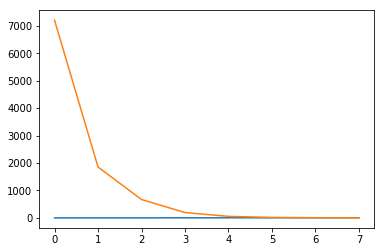

In [9]:
Plot(eval_data,eval_labels,mnist_classifier)

In [23]:
print("Training Data = ",database.shape[0])
print("Test Data = ",eval_data.shape[0])

Training Data =  1920
Test Data =  299


2


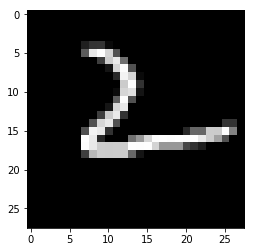

In [24]:
c = np.random.randint(0,eval_data.shape[0])
SP.Display(eval_data,c)
print(eval_labels[c])

In [29]:
data = np.copy(SP.Rotation(eval_data,30))

In [31]:
a, b, c, d, e, f = SP.Test(train_data, train_labels, data, eval_labels,
                           mnist_classifier, 1)

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.95, 'loss': 0.28519097, 'global_step': 8004}
######### Test accuracy #############
 {'accuracy': 0.2742475, 'loss': 4.5564632, 'global_step': 8004}


In [26]:
graph = []

In [27]:
graph.append(["Samples = " , samples])
graph.append(['Training set = ', database.shape[0]])
graph.append(["Test Data = ", eval_data.shape[0]])
graph.append(["Training Accuracy : ",a[1]])
graph.append(["Test Accuracy : ",d[1]])

In [28]:
for i in graph:
    print(i)

['Samples = ', 15]
['Training set = ', 1920]
['Test Data = ', 299]
['Training Accuracy : ', 0.95]
['Test Accuracy : ', 0.33110368]


In [ ]:
name = tf.estimator.Estimator.get_variable_names(mnist_classifier)
a = []
for i in name:
    a.append(tf.estimator.Estimator.get_variable_value(name=i,self=mnist_classifier))

In [ ]:
for i in a:
    print(i.shape)

In [167]:
%%capture
a = []
t = [0,15,30,45,60,90,135,180,225,275]
for i in t:
    g = np.copy(eval_data)
    eval_data_temp = SP.Rotation(g,i)
    a.append(SP.Test(train_data,train_labels,eval_data_temp,eval_labels,mnist_classifier,1)[3])

In [168]:
a = np.array(a)
a = a.T

In [182]:
b = []
for i in range(0,a.shape[1]):
    b.append((t[i],a[1][i]))
print(b)

[(0, '0.7067308'), (15, '0.63461536'), (30, '0.44230768'), (45, '0.22836539'), (60, '0.16346154'), (90, '0.125'), (135, '0.17548077'), (180, '0.31490386'), (225, '0.16586539'), (275, '0.14903846')]
